In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as Data
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
import numpy as np
import matplotlib.pyplot as plt
import os
import cProfile, pstats, io
from pstats import SortKey
from random import randint
from Utillities import Utillities
from cnn_model import CNN6     


print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

if os.path.exists("checkpoint.pt"):
    os.remove("checkpoint.pt")

torch.manual_seed(1)   # reproducible

OPTIMIZATION_PLUGIN = 'Bayesian' # 'Bayesian' or 'Scikit' or 'GradDescent'
#Bayesian requires: $ conda install -c conda-forge bayesian-optimization

GET_STATS = False
GPU_SELECT = 2 # can be 0, 1, 2 (both)
PARALLEL_PROCESSES = 2
TRIALS = 30
RANDOM_STARTS = 300
LR  = 1e-5                    # learning rate
SCI_LR =  1e-5
LR2 = 1e-5
SCI_MM = 0.5                  # momentum - used only with SGD optimizer
MM = 0.5
L_FIRST = 14                  # initial number of channels
KERNEL_X = 14
patience = 7                 # if validation loss not going down, wait "patience" number of epochs
accuracy = 0
MaxPercent = 0

PercentVector = np.zeros(RANDOM_STARTS + TRIALS)
PercentVec = np.zeros(RANDOM_STARTS + TRIALS)
count = 0

pr = cProfile.Profile()

if GET_STATS:
    pr.enable()
    

if GPU_SELECT == 2:
    if torch.cuda.device_count() > 1:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print("Using", torch.cuda.device_count(), "NVIDIA 1080TI GPUs!")

if GPU_SELECT == 1:
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")    
    print("Using one (the second) NVIDIA 1080TI GPU!")

if GPU_SELECT == 0:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")       
    print("Using one (the first) NVIDIA 1080TI GPU!")


PyTorch Version:  1.2.0
Torchvision Version:  0.4.0a0+6b959ee
Using 2 NVIDIA 1080TI GPUs!


In [2]:
from early_stopping import EarlyStopping
from dataset import dataset


early_stopping = EarlyStopping(patience=patience, verbose=True)  # initialize the early_stopping object

# Counter for the execution time
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

start.record()

In [3]:
if OPTIMIZATION_PLUGIN == 'Scikit' :
    from skopt import gp_minimize
    from sklearn.datasets import load_boston
    from sklearn.ensemble import GradientBoostingRegressor
    from sklearn.model_selection import cross_val_score
    from skopt.space import Real, Integer
    from skopt.utils import use_named_args
    from skopt.plots import plot_convergence
    from functools import partial
    from skopt.plots import plot_evaluations
    from skopt import gp_minimize, forest_minimize, dummy_minimize, gbrt_minimize
    from skopt.plots import plot_objective
    from sklearn.preprocessing import LabelEncoder
    from skopt.space import Real, Categorical, Integer
    from sklearn.externals.joblib import Parallel, delayed

    SCI_LR = Categorical(categories=[1e-1, 3e-1, 5e-1, 7e-1, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.08, 0.09],name= 'SCI_LR')
    SCI_MM = Categorical(categories=[0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99, 0.999], name='SCI_MM')
    SCI_REGULARIZATION = Categorical(categories=[0.0001, 0.0003, 0.0007, 0.001, 0.003, 0.007, 0.01, 0.03, 0.07, 0.1, 0.3, 0.7], name='SCI_REGULARIZATION')
    SCI_EPOCHS = Categorical(categories=[2000, 1000], name='SCI_EPOCHS')
    SCI_optimizer = Categorical(categories=['Adam', 'AMSGrad', 'SGD', 'RMSprop', 'Rprop', 'AdamW', 'ASGD', 'Adadelta', 'Adamax'],name='SCI_optimizer') #
    SCI_loss_type = Categorical(categories=['CrossEntropyLoss', 'MultiMarginLoss','NLLLoss', 'L1Loss'],name='SCI_loss_type') # 
    SCI_BATCH_SIZE = Categorical(categories=[4, 8, 12, 16, 24, 32, 48, 64, 80, 96, 104, 128, 144, 160, 192, 224, 256], name='SCI_BATCH_SIZE')
    SCI_DROPOUT = Categorical(categories=[0, 0.01, 0.03, 0.07, 0.1, 0.13, 0.17, 0.2, 0.23, 0.27, 0.3, 0.33, 0.37, 0.4] , name = 'SCI_DROPOUT')
    SCI_RELU = Categorical(categories=['True', 'False'] , name = 'SCI_RELU')
    SCI_BIAS = Categorical(categories=['True', 'False'] , name = 'SCI_BIAS')
    SCI_L_SECOND = Categorical(categories=[2, 4, 6, 8, 12, 16, 20, 24, 32, 48, 64], name='SCI_L_SECOND')
    SCI_BN_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_BN_MOMENTUM') 
    SCI_SGD_MOMENTUM = Categorical(categories=[0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99] , name = 'SCI_SGD_MOMENTUM') 
    SCI_LINEARITY = Categorical(categories=[1, 2],name= 'SCI_LINEARITY')
   

    dimensions = [SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY]

    @use_named_args(dimensions = dimensions)

    def objective(SCI_BATCH_SIZE, SCI_MM, SCI_REGULARIZATION, SCI_optimizer, SCI_LR, SCI_loss_type, SCI_DROPOUT, SCI_RELU, SCI_BIAS, SCI_L_SECOND, SCI_EPOCHS, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY):
        global device  

        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            if LOSS == 'CrossEntropyLoss':
                loss_func = nn.CrossEntropyLoss()
            if LOSS == 'NLLLoss':
                loss_func = nn.NLLLoss()
            else:
                loss_func = nn.MultiMarginLoss()
            return loss_func

        MM = float(str(SCI_MM))
        REGULARIZATION = float(str(SCI_REGULARIZATION))
        optimizer = str(SCI_optimizer)
        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)
 
        loss_type = create_loss(SCI_loss_type)
                
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, SCI_DROPOUT, dataset.CLASSES, SCI_LINEARITY)     

        optimizer = Utillities.optimization_algorithms(SCI_optimizer,cnn, SCI_LR, SCI_SGD_MOMENTUM,
                                                       SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()
     

        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, SCI_L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, SCI_loss_type, REGULARIZATION, SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)
    
        #SCI_BATCH_SIZE = 1
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = SCI_BATCH_SIZE, shuffle = False, num_workers = 0, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                    #ps = torch.exp(output)
                    #equality = (validation_target[0].data == ps.max(dim=1)[1])
                    #accuracy += equality.type(torch.FloatTensor).mean()      
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    #nn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5)
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
        print('Credit Cost: ',CreditCost)
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        return CreditCost
    
    #not working #res_gp = gp_minimize(objective, dimensions=dimensions, n_calls=TRIALS, random_state=1, verbose=True, acq_func='gp_hedge', acq_optimizer='auto', n_jobs=1)
    res_gp = forest_minimize(objective, dimensions=dimensions, base_estimator='RF', n_calls=TRIALS, n_random_starts=RANDOM_STARTS, acq_func='EI', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=10000, xi=0.01, kappa=1.5, n_jobs=4)
    #res_gp = gbrt_minimize(objective, dimensions=dimensions, base_estimator='ET', n_calls=TRIALS+RANDOM_STARTS, n_random_starts=RANDOM_STARTS, acq_func='LCB', x0=None, y0=None, random_state=None, verbose=True, callback=None, n_points=100, xi=0.01, kappa=1.96, n_jobs=1)
    #res_gp = dummy_minimize(objective, dimensions=dimensions, n_calls=TRIALS, x0=None, y0=None, random_state=None, verbose=True, callback=None)      

    "Best score=%.4f" % res_gp.fun
    print("""Best parameters: - optimization=%d""" % (res_gp.x[0]))
  
    print(res_gp)
    plot_convergence(res_gp)
    #plot_evaluations(res_gp)
    #plot_objective(res_gp)
    

|   iter    |  target   | SCI_BA... | SCI_BIAS  | SCI_BN... | SCI_DR... | SCI_EP... | SCI_LI... |  SCI_LR   | SCI_L_... |  SCI_MM   | SCI_RE... | SCI_RELU  | SCI_SG... | SCI_lo... | SCI_op... |
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.16764
    weight_decay: 0.3772178321289495
)
Batch Normalization Momentum:  0.0
Nodes:  45
LR:  0.16764
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3772178321289495
BATCH_SIZE:  54
Dropout:  0.24
Final Linear Layers:  1
average loss: 16.030704
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9561)
Class:  0  correct:  109.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2907)
Class:  1  correct:  25.0  of  tensor(86.)


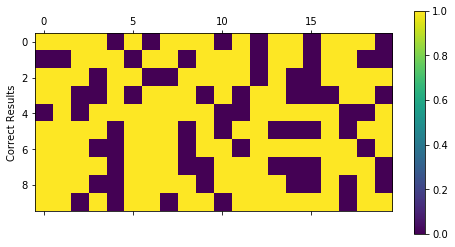

Final percentage:  tensor(0.6234)
Last epoch:  13


Best Score So Far:  tensor(-0.6234)


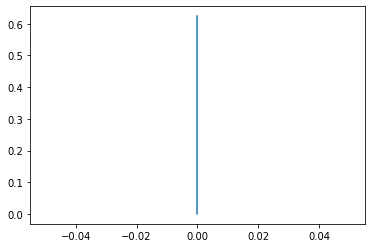

|  1        | -0.6234   |  54.54    |  2.433    |  0.000113 |  0.2419   |  1.147e+0 |  1.276    |  0.1676   |  45.54    |  0.397    |  0.3772   |  1.834    |  0.6784   |  1.611    |  8.894    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.72067
    weight_decay: 0.4846565987069529
)
Batch Normalization Momentum:  0.41
Nodes:  124
LR:  0.72067
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4846565987069529
BATCH_SIZE:  5
Dropout:  0.45
Final Linear Layers:  1
average loss: 0.795551
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9211)
Class:  0  correct:  105.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3140)
Class:  1  correct:  27.0  of  tensor(86.)


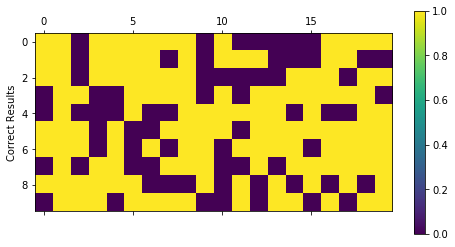

Final percentage:  tensor(0.6175)
Last epoch:  15


Best Score So Far:  tensor(-0.6234)


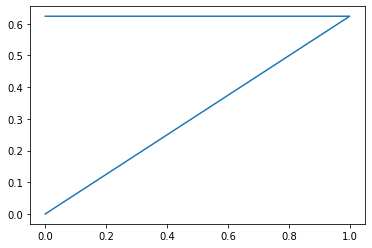

|  2        | -0.6175   |  5.451    |  2.334    |  0.4131   |  0.447    |  1.14e+03 |  1.592    |  0.7207   |  124.0    |  0.3138   |  0.4847   |  2.744    |  0.8857   |  1.254    |  1.351    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.62269
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.1
Nodes:  41
LR:  0.62269
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5842545077609712
BATCH_SIZE:  23
Dropout:  0.34
Final Linear Layers:  2
average loss: 447.302002
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9302)
Class:  1  correct:  80.0  of  tensor(86.)


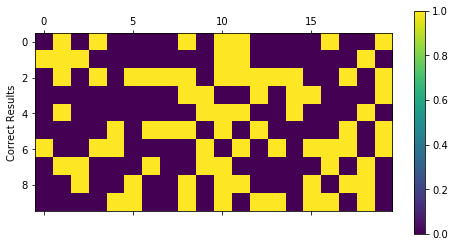

Final percentage:  tensor(0.4651)
Last epoch:  10


Best Score So Far:  tensor(-0.6234)


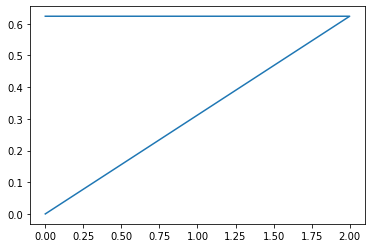

|  3        | -0.4651   |  23.4     |  2.748    |  0.09736  |  0.3369   |  1.958e+0 |  2.594    |  0.6227   |  41.75    |  0.6861   |  0.5843   |  1.036    |  0.7426   |  3.957    |  7.726    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.259
    weight_decay: 0.47521698950462965
)
Batch Normalization Momentum:  0.1
Nodes:  18
LR:  0.259
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.47521698950462965
BATCH_SIZE:  37
Dropout:  0.36
Final Linear Layers:  1
average loss: 11.610855
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8860)
Class:  0  correct:  101.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3372)
Class:  1  correct:  29.0  of  tensor(86.)


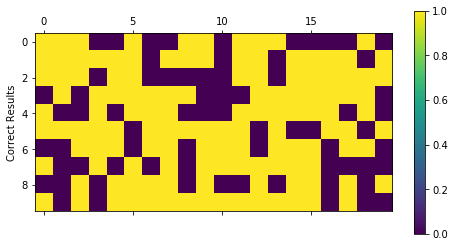

Final percentage:  tensor(0.6116)
Last epoch:  12


Best Score So Far:  tensor(-0.6234)


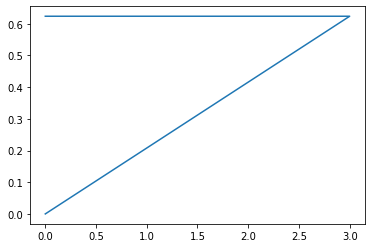

|  4        | -0.6116   |  37.34    |  2.571    |  0.1022   |  0.3583   |  1.909e+0 |  1.878    |  0.259    |  18.38    |  0.02033  |  0.4752   |  1.421    |  0.2629   |  2.47     |  1.48     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.62496
    rho: 0.9
    weight_decay: 0.3751738945002665
)
Batch Normalization Momentum:  0.58
Nodes:  54
LR:  0.62496
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3751738945002665
BATCH_SIZE:  74
Dropout:  0.56
Final Linear Layers:  2
average loss: 172.859100
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6842)
Class:  0  correct:  78.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.5116)
Class:  1  correct:  44.0  of  tensor(86.)


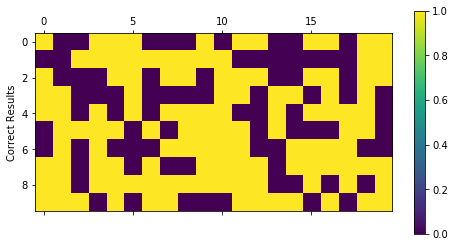

Final percentage:  tensor(0.5979)
Last epoch:  32


Best Score So Far:  tensor(-0.6234)


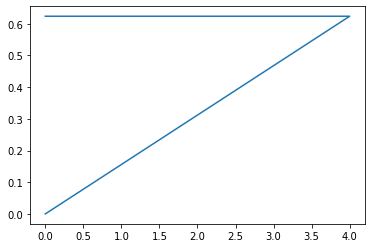

|  5        | -0.5979   |  74.34    |  1.292    |  0.5834   |  0.5598   |  1.102e+0 |  2.238    |  0.625    |  54.19    |  0.05085  |  0.3752   |  2.321    |  0.5097   |  3.824    |  6.273    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.83476
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.14
Nodes:  45
LR:  0.83476
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5082259899467809
BATCH_SIZE:  115
Dropout:  0.65
Final Linear Layers:  1
average loss: 159.292862
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0116)
Class:  1  correct:  1.0  of  tensor(86.)


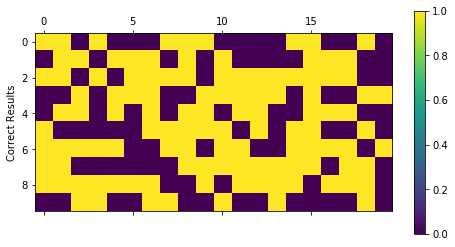

Final percentage:  tensor(0.5058)
Last epoch:  12


Best Score So Far:  tensor(-0.6234)


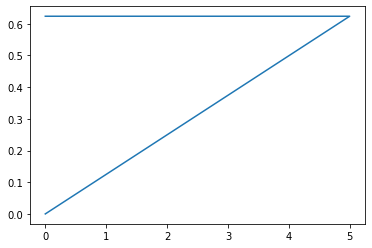

|  6        | -0.5058   |  115.8    |  1.274    |  0.1379   |  0.6459   |  1.398e+0 |  1.494    |  0.8348   |  45.82    |  0.7503   |  0.5082   |  2.758    |  0.6174   |  3.245    |  4.137    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.10328
    rho: 0.9
    weight_decay: 0.4049148911095535
)
Batch Normalization Momentum:  0.42
Nodes:  121
LR:  0.10328
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4049148911095535
BATCH_SIZE:  36
Dropout:  0.77
Final Linear Layers:  2
average loss: 46.973701
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9767)
Class:  1  correct:  84.0  of  tensor(86.)


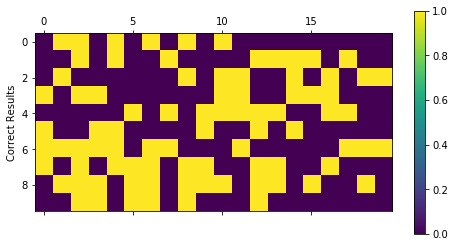

Final percentage:  tensor(0.4884)
Last epoch:  21


Best Score So Far:  tensor(-0.6234)


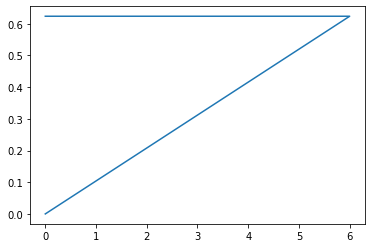

|  7        | -0.4884   |  36.01    |  2.783    |  0.4238   |  0.7719   |  1.663e+0 |  2.859    |  0.1033   |  121.6    |  0.45     |  0.4049   |  1.812    |  0.2347   |  3.701    |  6.157    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.81768
    weight_decay: 0.6506131198972585
)
Batch Normalization Momentum:  0.32
Nodes:  80
LR:  0.81768
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.6506131198972585
BATCH_SIZE:  2
Dropout:  0.42
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(86.)


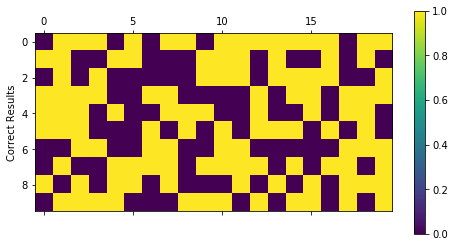

Final percentage:  tensor(0.5000)
Last epoch:  7


Best Score So Far:  tensor(-0.6234)


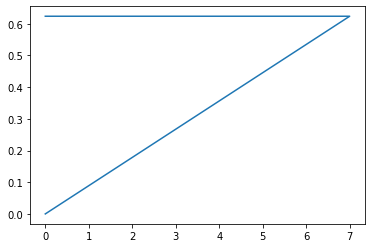

|  8        | -0.5      |  2.362    |  2.228    |  0.3234   |  0.4216   |  1.886e+0 |  2.068    |  0.8177   |  80.54    |  0.01679  |  0.6506   |  2.375    |  0.9873   |  1.515    |  2.233    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.64038
    momentum: 0.24
    nesterov: False
    weight_decay: 0.01844506971571572
)
Batch Normalization Momentum:  0.07
Nodes:  17
LR:  0.64038
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.01844506971571572
BATCH_SIZE:  119
Dropout:  0.6
Final Linear Layers:  3
average loss: 15.005394
average loss: 0.693250
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6579)
Class:  0  correct:  75.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3140)
Class:  1  correct:  27.0  of  tensor(86.)


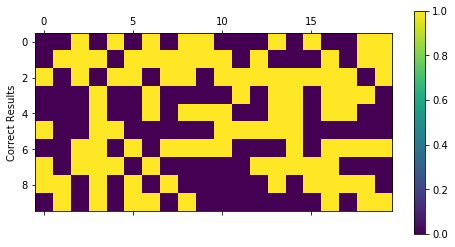

Final percentage:  tensor(0.4859)
Last epoch:  130


Best Score So Far:  tensor(-0.6234)


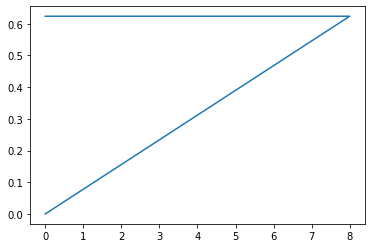

|  9        | -0.4859   |  119.5    |  2.387    |  0.06534  |  0.6044   |  1.754e+0 |  3.76     |  0.6404   |  17.66    |  0.02084  |  0.01845  |  1.056    |  0.2437   |  3.571    |  5.844    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.50493
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.12
Nodes:  4
LR:  0.50493
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.16315869426133017
BATCH_SIZE:  71
Dropout:  0.22
Final Linear Layers:  3
average loss: 407.916473
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9651)
Class:  1  correct:  83.0  of  tensor(86.)


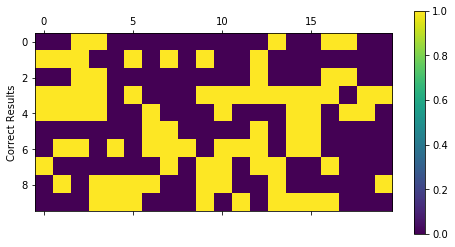

Final percentage:  tensor(0.4826)
Last epoch:  7


Best Score So Far:  tensor(-0.6234)


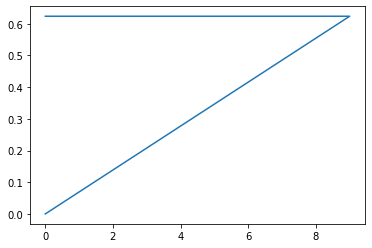

|  10       | -0.4826   |  71.66    |  2.676    |  0.1229   |  0.2233   |  1.586e+0 |  3.899    |  0.5049   |  4.35     |  0.8      |  0.1632   |  2.606    |  0.384    |  3.582    |  7.717    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.20315
    weight_decay: 0.008887930513365184
)
Batch Normalization Momentum:  0.06
Nodes:  91
LR:  0.20315
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.008887930513365184
BATCH_SIZE:  72
Dropout:  0.1
Final Linear Layers:  1
average loss: 291.316284
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9825)
Class:  0  correct:  112.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1395)
Class:  1  correct:  12.0  of  tensor(86.)


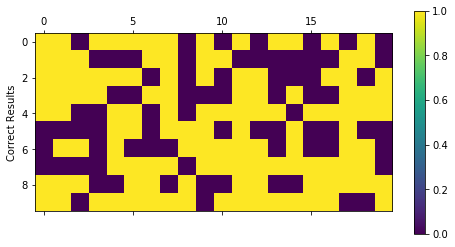

Final percentage:  tensor(0.5610)
Last epoch:  16


Best Score So Far:  tensor(-0.6234)


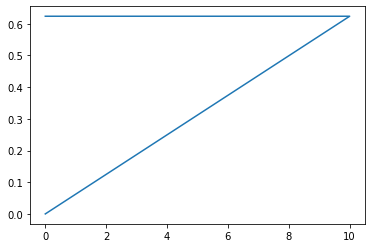

|  11       | -0.561    |  72.09    |  1.272    |  0.05932  |  0.09707  |  1.045e+0 |  1.321    |  0.2031   |  91.84    |  0.5596   |  0.008888 |  1.143    |  0.9576   |  2.699    |  2.828    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.21587
    momentum: 0.02
    nesterov: False
    weight_decay: 0.58030373159517
)
Batch Normalization Momentum:  0.19
Nodes:  64
LR:  0.21587
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.58030373159517
BATCH_SIZE:  33
Dropout:  0.47
Final Linear Layers:  3
average loss: 5.830920
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1512)
Class:  1  correct:  13.0  of  tensor(86.)


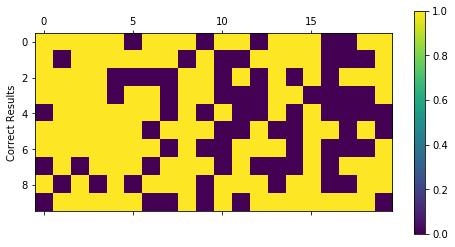

Final percentage:  tensor(0.5712)
Last epoch:  8


Best Score So Far:  tensor(-0.6234)


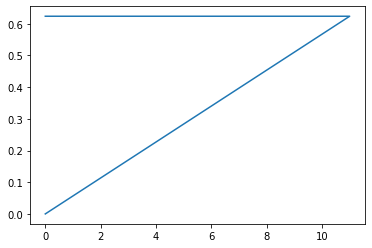

|  12       | -0.5712   |  33.79    |  2.48     |  0.1935   |  0.4651   |  1.97e+03 |  3.532    |  0.2159   |  64.21    |  0.6197   |  0.5803   |  1.312    |  0.01839  |  1.209    |  5.372    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.49586
    weight_decay: 0.18551719840820027
)
Batch Normalization Momentum:  0.31
Nodes:  95
LR:  0.49586
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.18551719840820027
BATCH_SIZE:  78
Dropout:  0.79
Final Linear Layers:  2
average loss: 2687.789307
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1279)
Class:  1  correct:  11.0  of  tensor(86.)


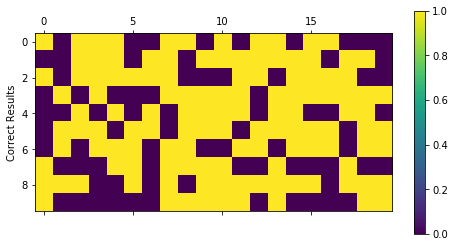

Final percentage:  tensor(0.5596)
Last epoch:  27


Best Score So Far:  tensor(-0.6234)


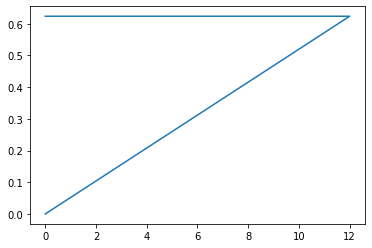

|  13       | -0.5596   |  78.4     |  2.132    |  0.3142   |  0.7909   |  1.58e+03 |  2.137    |  0.4959   |  95.91    |  0.6689   |  0.1855   |  1.132    |  0.3664   |  2.883    |  2.889    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.47221
    t0: 1000000.0
    weight_decay: 0.04626616736974824
)
Batch Normalization Momentum:  0.26
Nodes:  118
LR:  0.47221
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.04626616736974824
BATCH_SIZE:  96
Dropout:  0.64
Final Linear Layers:  2
average loss: 15.046218
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.1228)
Class:  0  correct:  14.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6163)
Class:  1  correct:  53.0  of  tensor(86.)


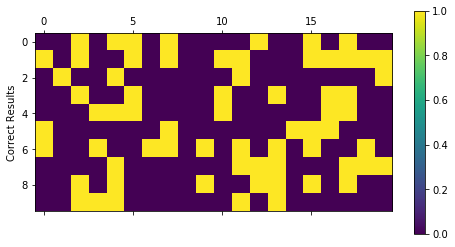

Final percentage:  tensor(0.3695)
Last epoch:  73


Best Score So Far:  tensor(-0.6234)


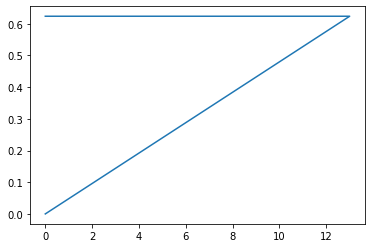

|  14       | -0.3695   |  96.85    |  1.132    |  0.2577   |  0.6438   |  1.193e+0 |  2.912    |  0.4722   |  118.5    |  0.2638   |  0.04627  |  2.463    |  0.7645   |  3.714    |  9.378    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.82405
    t0: 1000000.0
    weight_decay: 0.3402448679011271
)
Batch Normalization Momentum:  0.61
Nodes:  82
LR:  0.82405
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3402448679011271
BATCH_SIZE:  3
Dropout:  0.76
Final Linear Layers:  2
average loss: 0.693147
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(86.)


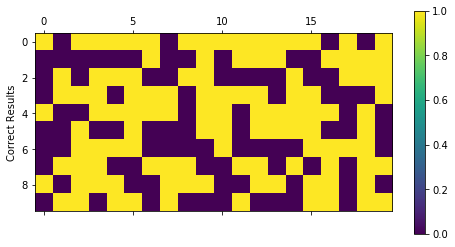

Final percentage:  tensor(0.5000)
Last epoch:  7


Best Score So Far:  tensor(-0.6234)


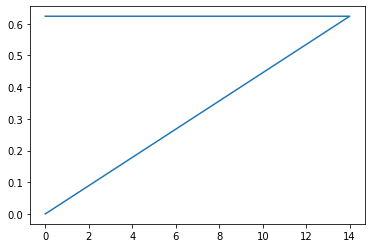

|  15       | -0.5      |  3.758    |  1.466    |  0.6106   |  0.7592   |  1.95e+03 |  2.664    |  0.824    |  82.84    |  0.3902   |  0.3402   |  2.203    |  0.5441   |  3.769    |  9.259    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01938
    weight_decay: 0.010611784621411451
)
Batch Normalization Momentum:  0.17
Nodes:  121
LR:  0.01938
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.010611784621411451
BATCH_SIZE:  51
Dropout:  0.1
Final Linear Layers:  2
average loss: 3.717069
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2209)
Class:  1  correct:  19.0  of  tensor(86.)


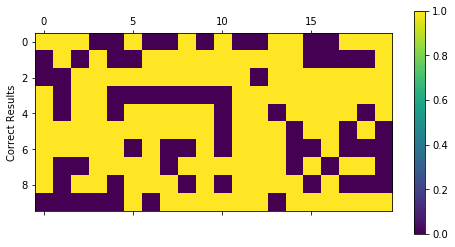

Final percentage:  tensor(0.6105)
Last epoch:  11


Best Score So Far:  tensor(-0.6234)


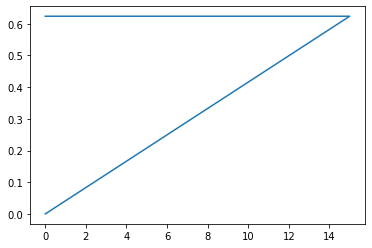

|  16       | -0.6105   |  51.75    |  2.917    |  0.1722   |  0.1011   |  1.135e+0 |  2.512    |  0.01938  |  121.4    |  0.8265   |  0.01061  |  1.351    |  0.3287   |  1.392    |  8.277    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.4139
    rho: 0.9
    weight_decay: 0.20007462432872986
)
Batch Normalization Momentum:  0.58
Nodes:  70
LR:  0.4139
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.20007462432872986
BATCH_SIZE:  45
Dropout:  0.7
Final Linear Layers:  3
average loss: 167.892792
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.1754)
Class:  0  correct:  20.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6279)
Class:  1  correct:  54.0  of  tensor(86.)


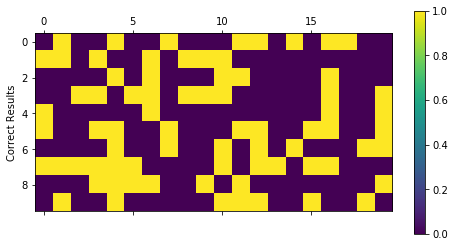

Final percentage:  tensor(0.4017)
Last epoch:  32


Best Score So Far:  tensor(-0.6234)


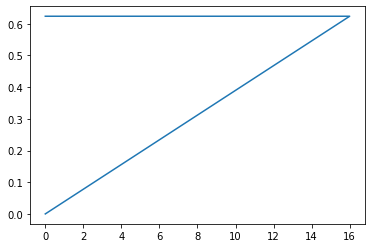

|  17       | -0.4017   |  45.44    |  2.871    |  0.5762   |  0.7031   |  1.845e+0 |  3.707    |  0.4139   |  70.84    |  0.798    |  0.2001   |  1.976    |  0.5931   |  1.046    |  6.335    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.70914
    t0: 1000000.0
    weight_decay: 0.2941935566327924
)
Batch Normalization Momentum:  0.31
Nodes:  79
LR:  0.70914
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.2941935566327924
BATCH_SIZE:  56
Dropout:  0.71
Final Linear Layers:  1
average loss: 1.045094
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0965)
Class:  0  correct:  11.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7209)
Class:  1  correct:  62.0  of  tensor(86.)


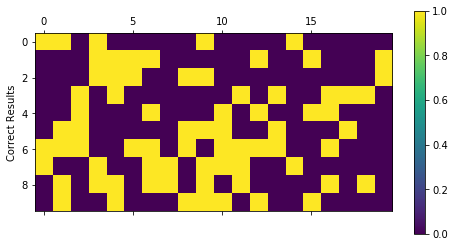

Final percentage:  tensor(0.4087)
Last epoch:  10


Best Score So Far:  tensor(-0.6234)


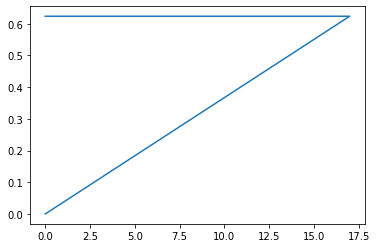

|  18       | -0.4087   |  56.64    |  2.607    |  0.3121   |  0.7143   |  1.578e+0 |  1.55     |  0.7091   |  79.12    |  0.0548   |  0.2942   |  2.351    |  0.9094   |  1.001    |  9.781    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.25703
    weight_decay: 0.6008338541166867
)
Batch Normalization Momentum:  0.6
Nodes:  75
LR:  0.25703
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6008338541166867
BATCH_SIZE:  49
Dropout:  0.66
Final Linear Layers:  2
average loss: 1.626586
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0702)
Class:  0  correct:  8.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6744)
Class:  1  correct:  58.0  of  tensor(86.)


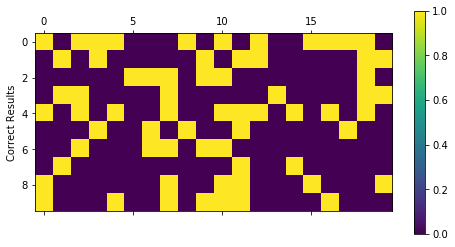

Final percentage:  tensor(0.3723)
Last epoch:  11


Best Score So Far:  tensor(-0.6234)


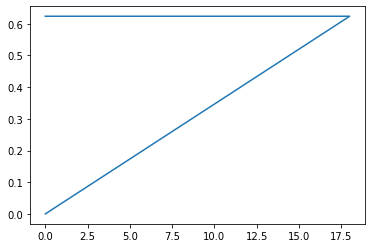

|  19       | -0.3723   |  49.45    |  2.938    |  0.5987   |  0.6631   |  1.575e+0 |  2.878    |  0.257    |  75.94    |  0.7495   |  0.6008   |  2.503    |  0.6911   |  3.585    |  3.901    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.55973
    weight_decay: 0.4744928439148743
)
Batch Normalization Momentum:  0.38
Nodes:  56
LR:  0.55973
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.4744928439148743
BATCH_SIZE:  86
Dropout:  0.33
Final Linear Layers:  1
average loss: 2.537605
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9651)
Class:  1  correct:  83.0  of  tensor(86.)


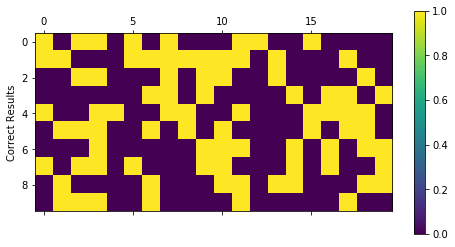

Final percentage:  tensor(0.4826)
Last epoch:  7


Best Score So Far:  tensor(-0.6234)


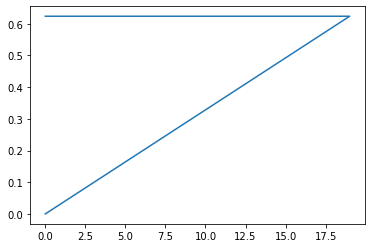

|  20       | -0.4826   |  86.52    |  1.897    |  0.3783   |  0.3286   |  1.401e+0 |  1.949    |  0.5597   |  56.21    |  0.9729   |  0.4745   |  1.395    |  0.4224   |  2.027    |  8.171    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.47495
    momentum: 0.76
    nesterov: False
    weight_decay: 0.513226453448729
)
Batch Normalization Momentum:  0.66
Nodes:  103
LR:  0.47495
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.513226453448729
BATCH_SIZE:  112
Dropout:  0.22
Final Linear Layers:  3
average loss: 1.445028
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8070)
Class:  0  correct:  92.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.4884)
Class:  1  correct:  42.0  of  tensor(86.)


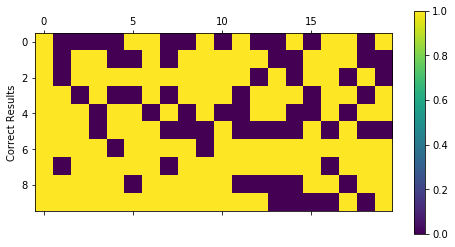

Final percentage:  tensor(0.6477)
Last epoch:  11


Best Score So Far:  tensor(-0.6477)


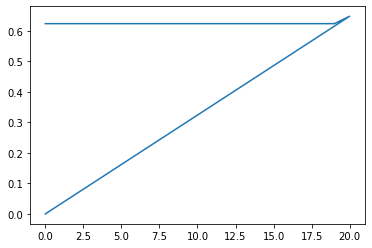

|  21       | -0.6477   |  112.9    |  2.799    |  0.6561   |  0.2162   |  1.252e+0 |  3.556    |  0.4749   |  103.1    |  0.5723   |  0.5132   |  2.033    |  0.7632   |  2.701    |  5.187    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.73067
    weight_decay: 0.39868913948048845
)
Batch Normalization Momentum:  0.37
Nodes:  112
LR:  0.73067
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.39868913948048845
BATCH_SIZE:  45
Dropout:  0.06
Final Linear Layers:  1
average loss: 0.704152
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9211)
Class:  0  correct:  105.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1047)
Class:  1  correct:  9.0  of  tensor(86.)


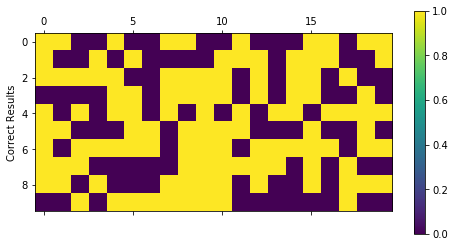

Final percentage:  tensor(0.5129)
Last epoch:  9


Best Score So Far:  tensor(-0.6477)


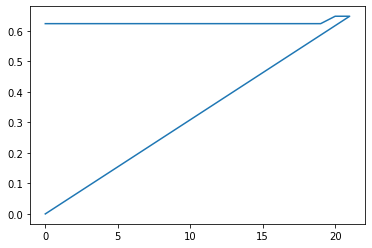

|  22       | -0.5129   |  45.18    |  1.136    |  0.3741   |  0.0637   |  1.983e+0 |  1.543    |  0.7307   |  112.2    |  0.688    |  0.3987   |  1.32     |  0.4622   |  2.032    |  3.023    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.17367
    rho: 0.9
    weight_decay: 0.14581528744231315
)
Batch Normalization Momentum:  0.91
Nodes:  64
LR:  0.17367
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.14581528744231315
BATCH_SIZE:  76
Dropout:  0.73
Final Linear Layers:  1
average loss: 397.739594
average loss: 0.693131
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.2544)
Class:  0  correct:  29.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.5349)
Class:  1  correct:  46.0  of  tensor(86.)


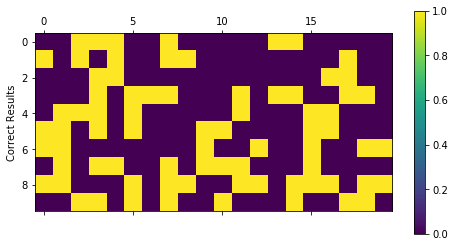

Final percentage:  tensor(0.3946)
Last epoch:  107


Best Score So Far:  tensor(-0.6477)


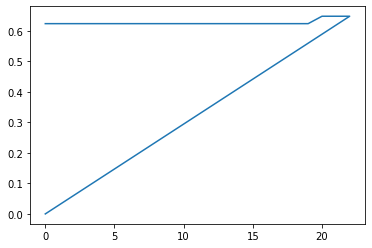

|  23       | -0.3946   |  76.66    |  1.621    |  0.9071   |  0.7277   |  1.257e+0 |  1.332    |  0.1737   |  64.95    |  0.7281   |  0.1458   |  1.494    |  0.8432   |  2.243    |  6.544    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.48961
    weight_decay: 0.5260943192129571
)
Batch Normalization Momentum:  0.51
Nodes:  84
LR:  0.48961
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5260943192129571
BATCH_SIZE:  31
Dropout:  0.38
Final Linear Layers:  2
average loss: 12448.724609
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9561)
Class:  0  correct:  109.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1163)
Class:  1  correct:  10.0  of  tensor(86.)


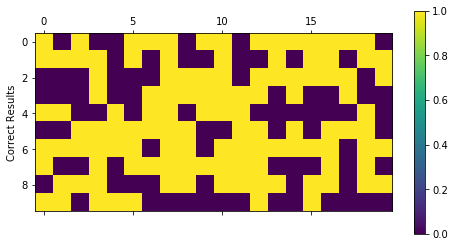

Final percentage:  tensor(0.5362)
Last epoch:  13


Best Score So Far:  tensor(-0.6477)


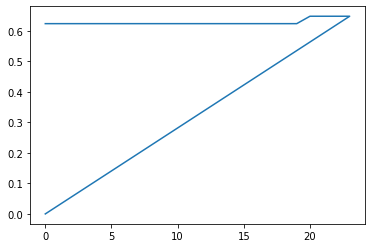

|  24       | -0.5362   |  31.44    |  1.203    |  0.5107   |  0.3817   |  1.153e+0 |  2.859    |  0.4896   |  84.42    |  0.1453   |  0.5261   |  1.442    |  0.5142   |  3.348    |  1.201    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.74377
    weight_decay: 0.4559479022054596
)
Batch Normalization Momentum:  0.84
Nodes:  109
LR:  0.74377
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4559479022054596
BATCH_SIZE:  42
Dropout:  0.43
Final Linear Layers:  3
average loss: 291.625580
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8684)
Class:  0  correct:  99.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3837)
Class:  1  correct:  33.0  of  tensor(86.)


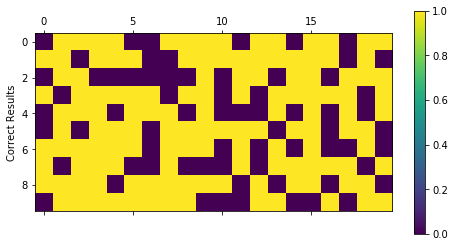

Final percentage:  tensor(0.6261)
Last epoch:  18


Best Score So Far:  tensor(-0.6477)


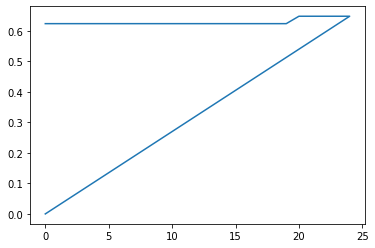

|  25       | -0.6261   |  42.87    |  2.737    |  0.8363   |  0.4308   |  1.867e+0 |  3.84     |  0.7438   |  109.6    |  0.09955  |  0.4559   |  2.4      |  0.6041   |  3.391    |  1.311    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.71693
    momentum: 0.14
    nesterov: False
    weight_decay: 0.693331201358326
)
Batch Normalization Momentum:  0.26
Nodes:  58
LR:  0.71693
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.693331201358326
BATCH_SIZE:  99
Dropout:  0.21
Final Linear Layers:  2
average loss: 0.689839
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(86.)


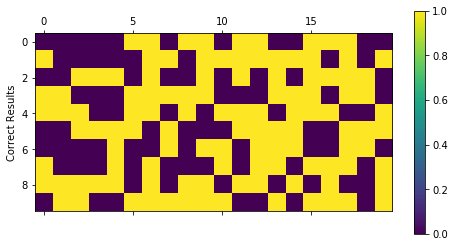

Final percentage:  tensor(0.5000)
Last epoch:  7


Best Score So Far:  tensor(-0.6477)


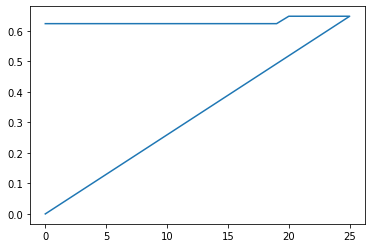

|  26       | -0.5      |  99.05    |  2.456    |  0.2571   |  0.2057   |  1.632e+0 |  2.032    |  0.7169   |  58.21    |  0.7822   |  0.6933   |  1.597    |  0.1416   |  3.695    |  5.869    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.32014
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.98
Nodes:  5
LR:  0.32014
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5219714711759764
BATCH_SIZE:  124
Dropout:  0.44
Final Linear Layers:  1
average loss: 282.708527
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9767)
Class:  1  correct:  84.0  of  tensor(86.)


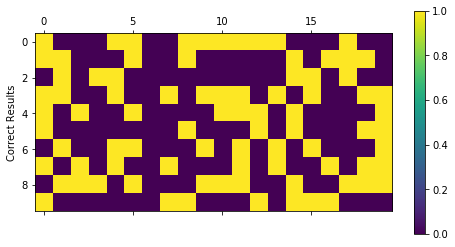

Final percentage:  tensor(0.4884)
Last epoch:  11


Best Score So Far:  tensor(-0.6477)


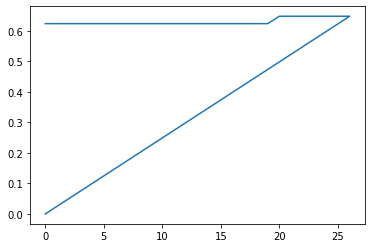

|  27       | -0.4884   |  124.8    |  2.267    |  0.984    |  0.4369   |  1.526e+0 |  1.405    |  0.3201   |  5.304    |  0.1611   |  0.522    |  1.06     |  0.3629   |  3.578    |  7.227    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.22297
    weight_decay: 0.31993703167224136
)
Batch Normalization Momentum:  0.44
Nodes:  35
LR:  0.22297
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.31993703167224136
BATCH_SIZE:  89
Dropout:  0.47
Final Linear Layers:  1
average loss: 70.707405
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1512)
Class:  1  correct:  13.0  of  tensor(86.)


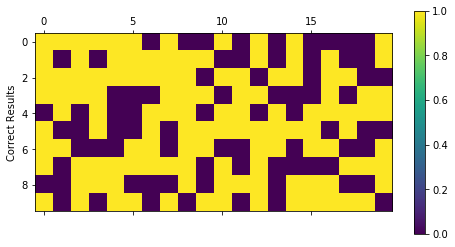

Final percentage:  tensor(0.5580)
Last epoch:  18


Best Score So Far:  tensor(-0.6477)


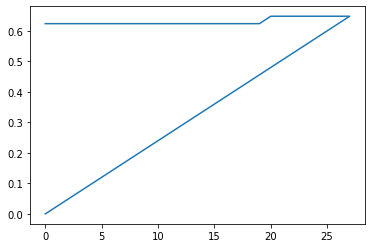

|  28       | -0.558    |  89.06    |  1.375    |  0.4375   |  0.4653   |  1.99e+03 |  1.61     |  0.223    |  35.03    |  0.7497   |  0.3199   |  1.113    |  0.5034   |  1.634    |  8.179    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.46003
    t0: 1000000.0
    weight_decay: 0.5627922279599029
)
Batch Normalization Momentum:  0.59
Nodes:  70
LR:  0.46003
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5627922279599029
BATCH_SIZE:  39
Dropout:  0.68
Final Linear Layers:  3
average loss: 0.768808
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3860)
Class:  0  correct:  44.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3953)
Class:  1  correct:  34.0  of  tensor(86.)


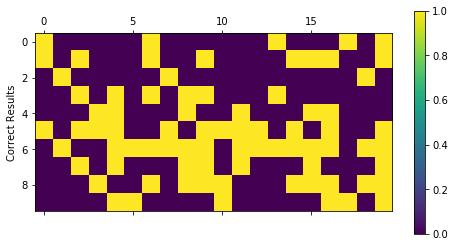

Final percentage:  tensor(0.3907)
Last epoch:  9


Best Score So Far:  tensor(-0.6477)


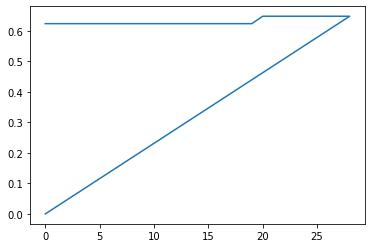

|  29       | -0.3907   |  39.46    |  1.055    |  0.5875   |  0.6751   |  1.381e+0 |  3.242    |  0.46     |  70.16    |  0.9585   |  0.5628   |  1.064    |  0.7023   |  2.39     |  9.518    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.72267
    rho: 0.9
    weight_decay: 0.2397836384784795
)
Batch Normalization Momentum:  0.08
Nodes:  89
LR:  0.72267
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.2397836384784795
BATCH_SIZE:  29
Dropout:  0.34
Final Linear Layers:  2
average loss: 6.677862
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.2193)
Class:  0  correct:  25.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6047)
Class:  1  correct:  52.0  of  tensor(86.)


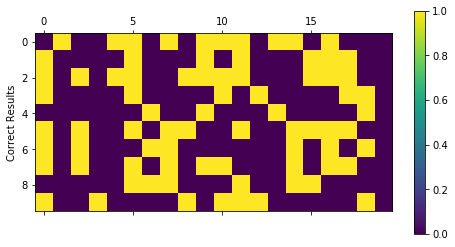

Final percentage:  tensor(0.4120)
Last epoch:  16


Best Score So Far:  tensor(-0.6477)


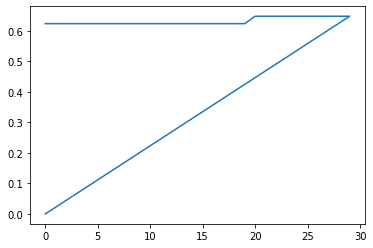

|  30       | -0.412    |  29.9     |  1.531    |  0.08066  |  0.3429   |  1.109e+0 |  2.895    |  0.7227   |  89.8     |  0.7657   |  0.2398   |  2.683    |  0.4245   |  3.464    |  6.632    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.02501
    momentum: 0.45
    nesterov: False
    weight_decay: 0.5228822530757068
)
Batch Normalization Momentum:  0.02
Nodes:  97
LR:  0.02501
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5228822530757068
BATCH_SIZE:  20
Dropout:  0.05
Final Linear Layers:  1
average loss: 231.951477
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0526)
Class:  0  correct:  6.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7093)
Class:  1  correct:  61.0  of  tensor(86.)


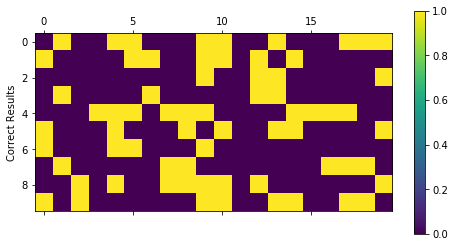

Final percentage:  tensor(0.3810)
Last epoch:  20


Best Score So Far:  tensor(-0.6477)


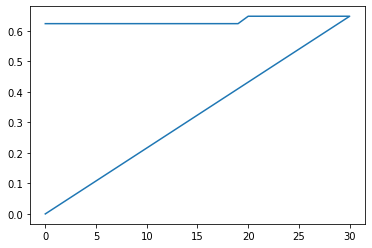

|  31       | -0.381    |  20.07    |  1.156    |  0.01815  |  0.05338  |  1.459e+0 |  1.339    |  0.02501  |  97.11    |  0.3951   |  0.5229   |  1.9      |  0.4456   |  2.429    |  5.261    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.55667
    t0: 1000000.0
    weight_decay: 0.002212267838055494
)
Batch Normalization Momentum:  0.9
Nodes:  3
LR:  0.55667
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.002212267838055494
BATCH_SIZE:  103
Dropout:  0.03
Final Linear Layers:  1
average loss: 260.157043
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0465)
Class:  1  correct:  4.0  of  tensor(86.)


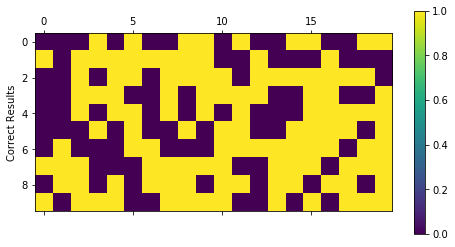

Final percentage:  tensor(0.5233)
Last epoch:  11


Best Score So Far:  tensor(-0.6477)


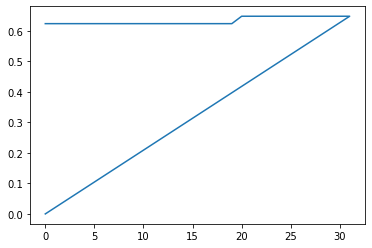

|  32       | -0.5233   |  103.2    |  1.801    |  0.8956   |  0.02965  |  1.774e+0 |  1.376    |  0.5567   |  3.306    |  0.5386   |  0.002212 |  2.893    |  0.8963   |  3.38     |  9.228    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.64001
    weight_decay: 0.2806715252865475
)
Batch Normalization Momentum:  0.19
Nodes:  94
LR:  0.64001
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.2806715252865475
BATCH_SIZE:  20
Dropout:  0.5
Final Linear Layers:  3
average loss: 33.819710
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.7895)
Class:  0  correct:  90.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.5000)
Class:  1  correct:  43.0  of  tensor(86.)


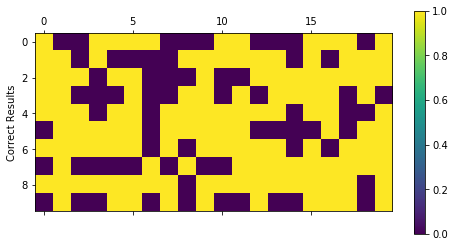

Final percentage:  tensor(0.6447)
Last epoch:  9


Best Score So Far:  tensor(-0.6477)


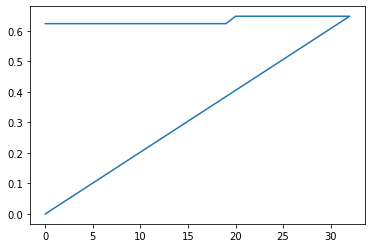

|  33       | -0.6447   |  20.34    |  1.314    |  0.1858   |  0.498    |  1.906e+0 |  3.96     |  0.64     |  94.21    |  0.9085   |  0.2807   |  1.497    |  0.1717   |  1.357    |  8.305    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.48029
    weight_decay: 0.256652995031479
)
Batch Normalization Momentum:  0.81
Nodes:  41
LR:  0.48029
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.256652995031479
BATCH_SIZE:  20
Dropout:  0.25
Final Linear Layers:  1
average loss: 2312.153076
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9561)
Class:  0  correct:  109.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2093)
Class:  1  correct:  18.0  of  tensor(86.)


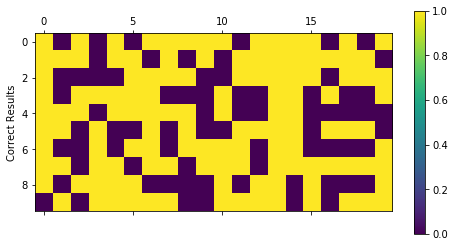

Final percentage:  tensor(0.5827)
Last epoch:  10


Best Score So Far:  tensor(-0.6477)


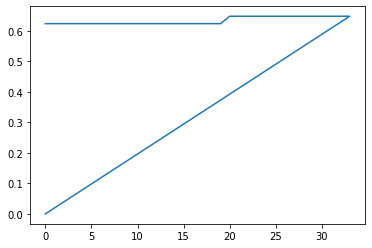

|  34       | -0.5827   |  20.5     |  1.526    |  0.8109   |  0.2485   |  1.982e+0 |  1.797    |  0.4803   |  41.62    |  0.91     |  0.2567   |  1.863    |  0.5072   |  3.807    |  1.278    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.50267
    weight_decay: 0.43985349536119783
)
Batch Normalization Momentum:  0.03
Nodes:  88
LR:  0.50267
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.43985349536119783
BATCH_SIZE:  92
Dropout:  0.42
Final Linear Layers:  3
average loss: 2.798044
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0614)
Class:  0  correct:  7.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7791)
Class:  1  correct:  67.0  of  tensor(86.)


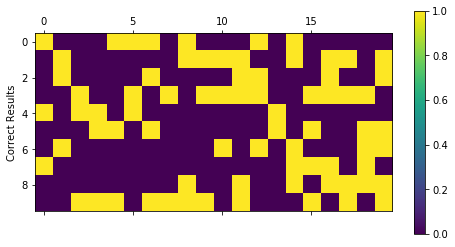

Final percentage:  tensor(0.4202)
Last epoch:  12


Best Score So Far:  tensor(-0.6477)


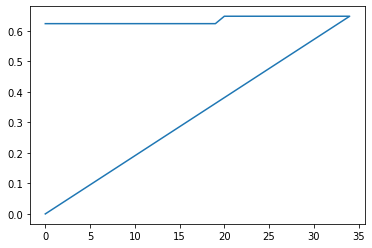

|  35       | -0.4202   |  92.33    |  2.773    |  0.02701  |  0.4176   |  1.326e+0 |  3.57     |  0.5027   |  88.97    |  0.4529   |  0.4399   |  1.577    |  0.009255 |  2.725    |  3.8      |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.84318
    weight_decay: 0.1596074129369267
)
Batch Normalization Momentum:  0.42
Nodes:  108
LR:  0.84318
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.1596074129369267
BATCH_SIZE:  67
Dropout:  0.2
Final Linear Layers:  3
average loss: 477118.312500
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1395)
Class:  1  correct:  12.0  of  tensor(86.)


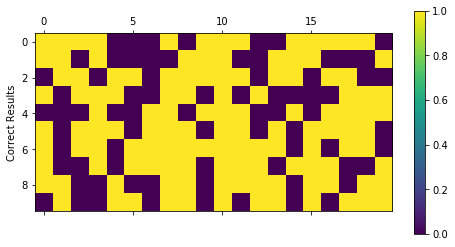

Final percentage:  tensor(0.5654)
Last epoch:  25


Best Score So Far:  tensor(-0.6477)


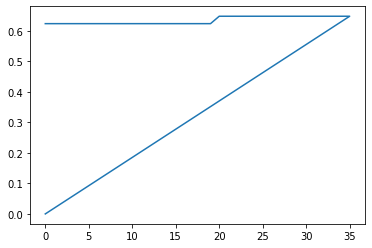

|  36       | -0.5654   |  67.18    |  2.824    |  0.4222   |  0.1979   |  1.371e+0 |  3.786    |  0.8432   |  108.4    |  0.9194   |  0.1596   |  1.174    |  0.225    |  1.94     |  2.571    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.5168
    weight_decay: 0.16024668830516706
)
Batch Normalization Momentum:  0.81
Nodes:  45
LR:  0.5168
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.16024668830516706
BATCH_SIZE:  78
Dropout:  0.15
Final Linear Layers:  1
average loss: 2556.211426
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1512)
Class:  1  correct:  13.0  of  tensor(86.)


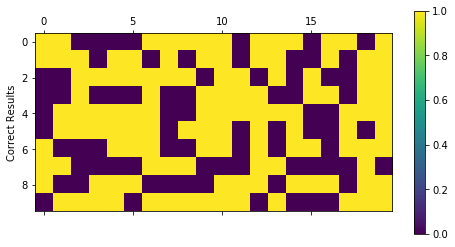

Final percentage:  tensor(0.5580)
Last epoch:  24


Best Score So Far:  tensor(-0.6477)


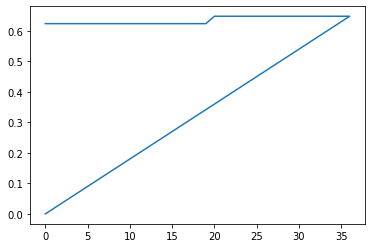

|  37       | -0.558    |  78.49    |  1.823    |  0.8082   |  0.1481   |  1.702e+0 |  1.719    |  0.5168   |  45.97    |  0.05785  |  0.1602   |  2.322    |  0.4923   |  2.552    |  2.571    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.53605
    weight_decay: 0.04585366335805425
)
Batch Normalization Momentum:  0.81
Nodes:  6
LR:  0.53605
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.04585366335805425
BATCH_SIZE:  73
Dropout:  0.48
Final Linear Layers:  3
average loss: 97.525558
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1047)
Class:  1  correct:  9.0  of  tensor(86.)


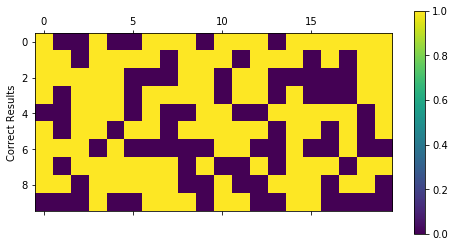

Final percentage:  tensor(0.5479)
Last epoch:  19


Best Score So Far:  tensor(-0.6477)


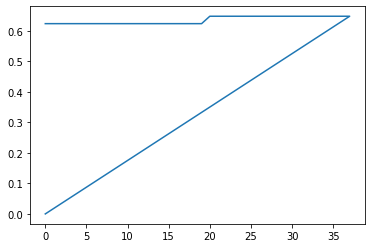

|  38       | -0.5479   |  73.91    |  2.984    |  0.8087   |  0.4755   |  1.976e+0 |  3.696    |  0.5361   |  6.086    |  0.09439  |  0.04585  |  1.899    |  0.3717   |  3.916    |  2.51     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.01183
    weight_decay: 0.511090838641964
)
Batch Normalization Momentum:  0.82
Nodes:  46
LR:  0.01183
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.511090838641964
BATCH_SIZE:  124
Dropout:  0.51
Final Linear Layers:  2
average loss: 73.959732
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9825)
Class:  0  correct:  112.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0465)
Class:  1  correct:  4.0  of  tensor(86.)


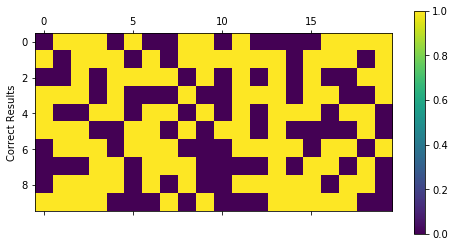

Final percentage:  tensor(0.5145)
Last epoch:  12


Best Score So Far:  tensor(-0.6477)


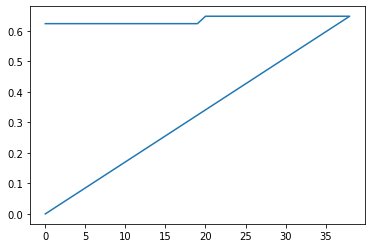

|  39       | -0.5145   |  124.6    |  2.527    |  0.816    |  0.5061   |  1.669e+0 |  2.426    |  0.01183  |  46.48    |  0.4921   |  0.5111   |  1.933    |  0.4528   |  1.412    |  1.098    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.6794
    weight_decay: 0.21881971480658544
)
Batch Normalization Momentum:  0.97
Nodes:  60
LR:  0.6794
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.21881971480658544
BATCH_SIZE:  97
Dropout:  0.18
Final Linear Layers:  2
average loss: 3866.163818
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1628)
Class:  1  correct:  14.0  of  tensor(86.)


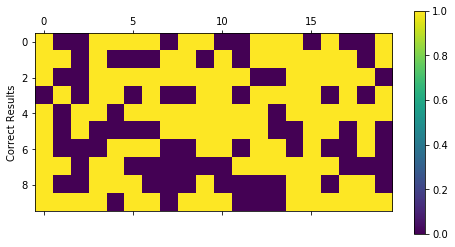

Final percentage:  tensor(0.5639)
Last epoch:  28


Best Score So Far:  tensor(-0.6477)


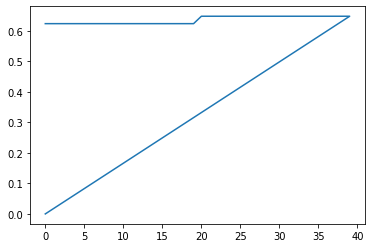

|  40       | -0.5639   |  97.54    |  1.637    |  0.9745   |  0.1762   |  1.339e+0 |  2.566    |  0.6794   |  60.45    |  0.1256   |  0.2188   |  2.004    |  0.6671   |  3.303    |  2.172    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.40433
    rho: 0.9
    weight_decay: 0.0037673623722609484
)
Batch Normalization Momentum:  0.8
Nodes:  117
LR:  0.40433
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.0037673623722609484
BATCH_SIZE:  4
Dropout:  0.01
Final Linear Layers:  3
average loss: 207.598587
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0614)
Class:  0  correct:  7.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6977)
Class:  1  correct:  60.0  of  tensor(86.)


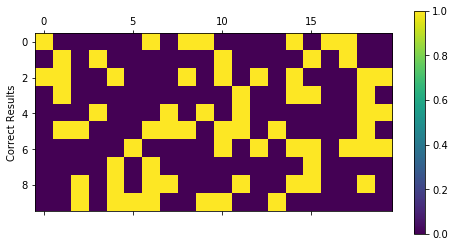

Final percentage:  tensor(0.3795)
Last epoch:  49


Best Score So Far:  tensor(-0.6477)


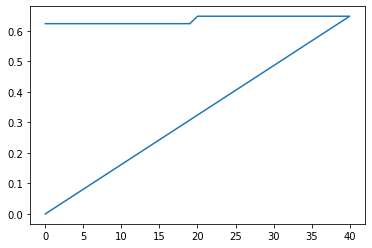

|  41       | -0.3795   |  4.887    |  2.033    |  0.8019   |  0.01008  |  1.672e+0 |  3.054    |  0.4043   |  117.3    |  0.6441   |  0.003767 |  1.964    |  0.8507   |  3.483    |  6.836    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.77025
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.27
Nodes:  26
LR:  0.77025
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.20279296205619549
BATCH_SIZE:  86
Dropout:  0.45
Final Linear Layers:  2
average loss: 359.304535
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0349)
Class:  1  correct:  3.0  of  tensor(86.)


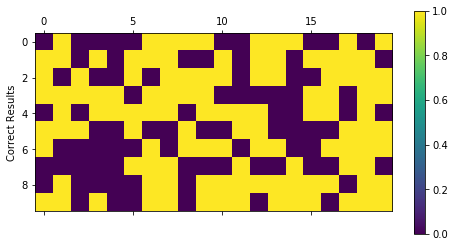

Final percentage:  tensor(0.5174)
Last epoch:  13


Best Score So Far:  tensor(-0.6477)


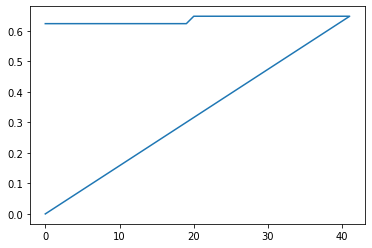

|  42       | -0.5174   |  86.89    |  2.151    |  0.2714   |  0.4484   |  1.672e+0 |  2.054    |  0.7702   |  26.57    |  0.7468   |  0.2028   |  2.54     |  0.4235   |  3.415    |  4.178    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.19271
    weight_decay: 0.2640201111852131
)
Batch Normalization Momentum:  0.31
Nodes:  27
LR:  0.19271
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2640201111852131
BATCH_SIZE:  28
Dropout:  0.59
Final Linear Layers:  1
average loss: 5.803089
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9825)
Class:  0  correct:  112.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2093)
Class:  1  correct:  18.0  of  tensor(86.)


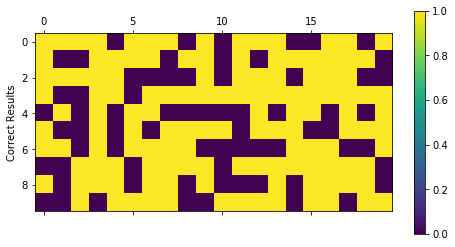

Final percentage:  tensor(0.5959)
Last epoch:  10


Best Score So Far:  tensor(-0.6477)


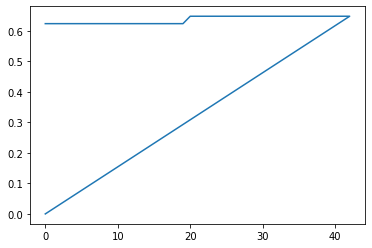

|  43       | -0.5959   |  28.93    |  2.527    |  0.3056   |  0.5866   |  1.744e+0 |  1.662    |  0.1927   |  27.07    |  0.1432   |  0.264    |  1.053    |  0.1098   |  3.017    |  8.19     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.27407
    t0: 1000000.0
    weight_decay: 0.6464270049616307
)
Batch Normalization Momentum:  0.21
Nodes:  107
LR:  0.27407
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6464270049616307
BATCH_SIZE:  12
Dropout:  0.73
Final Linear Layers:  2
average loss: 0.693158
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(86.)


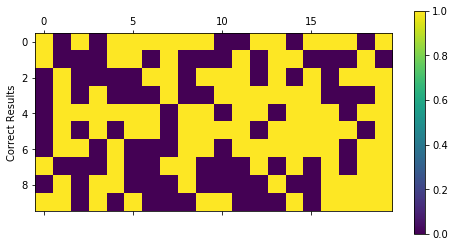

Final percentage:  tensor(0.5000)
Last epoch:  8


Best Score So Far:  tensor(-0.6477)


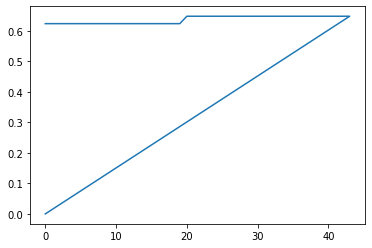

|  44       | -0.5      |  12.15    |  1.461    |  0.2055   |  0.7339   |  1.711e+0 |  2.656    |  0.2741   |  107.2    |  0.4354   |  0.6464   |  2.405    |  0.4733   |  1.377    |  9.775    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.16988
    rho: 0.9
    weight_decay: 0.14759160121911616
)
Batch Normalization Momentum:  0.43
Nodes:  83
LR:  0.16988
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.14759160121911616
BATCH_SIZE:  22
Dropout:  0.32
Final Linear Layers:  3
average loss: 305.620636
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0702)
Class:  0  correct:  8.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7326)
Class:  1  correct:  63.0  of  tensor(86.)


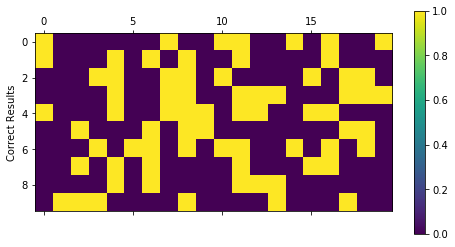

Final percentage:  tensor(0.4014)
Last epoch:  34


Best Score So Far:  tensor(-0.6477)


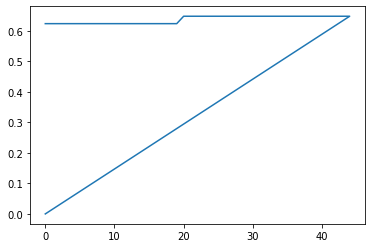

|  45       | -0.4014   |  22.14    |  1.403    |  0.4269   |  0.3234   |  1.147e+0 |  3.181    |  0.1699   |  83.13    |  0.7538   |  0.1476   |  2.196    |  0.7414   |  2.908    |  6.368    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.75175
    momentum: 0.9
    nesterov: False
    weight_decay: 0.21012672404315696
)
Batch Normalization Momentum:  0.94
Nodes:  26
LR:  0.75175
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.21012672404315696
BATCH_SIZE:  39
Dropout:  0.34
Final Linear Layers:  1
average loss: 71.910004
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6842)
Class:  0  correct:  78.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.5814)
Class:  1  correct:  50.0  of  tensor(86.)


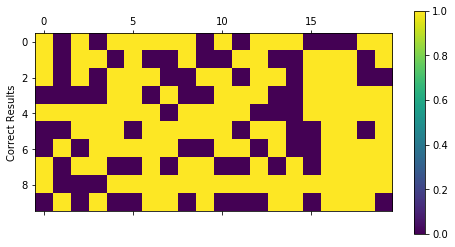

Final percentage:  tensor(0.6328)
Last epoch:  10


Best Score So Far:  tensor(-0.6477)


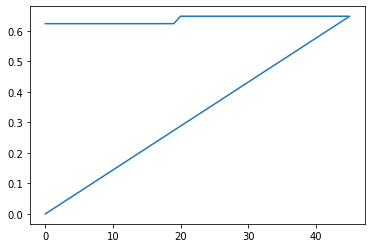

|  46       | -0.6328   |  39.23    |  2.456    |  0.9359   |  0.3404   |  1.782e+0 |  1.168    |  0.7517   |  26.22    |  0.3953   |  0.2101   |  1.159    |  0.8956   |  2.107    |  5.771    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.32136
    weight_decay: 0.07469805536448189
)
Batch Normalization Momentum:  0.2
Nodes:  15
LR:  0.32136
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.07469805536448189
BATCH_SIZE:  64
Dropout:  0.06
Final Linear Layers:  1
average loss: 6.509207
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9474)
Class:  0  correct:  108.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1512)
Class:  1  correct:  13.0  of  tensor(86.)


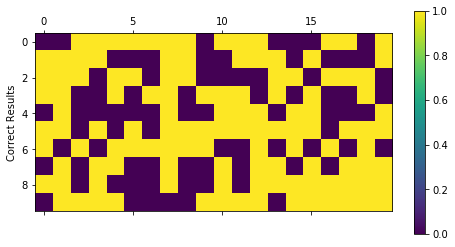

Final percentage:  tensor(0.5493)
Last epoch:  16


Best Score So Far:  tensor(-0.6477)


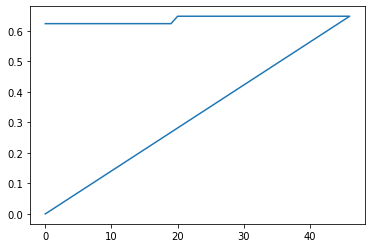

|  47       | -0.5493   |  64.26    |  1.263    |  0.2044   |  0.06095  |  1.508e+0 |  1.782    |  0.3214   |  15.62    |  0.787    |  0.0747   |  2.962    |  0.1754   |  2.711    |  1.403    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.19496
    rho: 0.9
    weight_decay: 0.1236666690905304
)
Batch Normalization Momentum:  0.52
Nodes:  97
LR:  0.19496
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.1236666690905304
BATCH_SIZE:  101
Dropout:  0.59
Final Linear Layers:  2
average loss: 37.802509
average loss: 0.686207
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8509)
Class:  0  correct:  97.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3256)
Class:  1  correct:  28.0  of  tensor(86.)


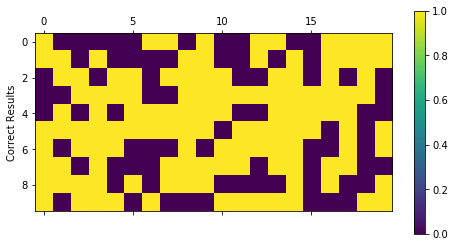

Final percentage:  tensor(0.5882)
Last epoch:  102


Best Score So Far:  tensor(-0.6477)


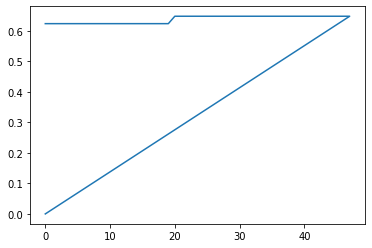

|  48       | -0.5882   |  101.2    |  1.377    |  0.5226   |  0.5921   |  1.15e+03 |  2.648    |  0.195    |  97.66    |  0.7225   |  0.1237   |  2.715    |  0.01958  |  3.572    |  6.025    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.84051
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.71
Nodes:  110
LR:  0.84051
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.3617304791667847
BATCH_SIZE:  52
Dropout:  0.79
Final Linear Layers:  1
average loss: 894.851135
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0349)
Class:  1  correct:  3.0  of  tensor(86.)


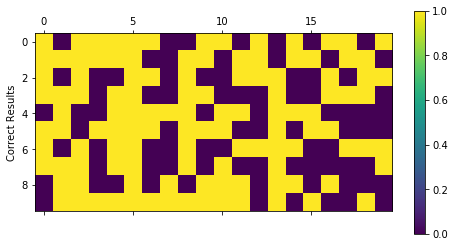

Final percentage:  tensor(0.5174)
Last epoch:  19


Best Score So Far:  tensor(-0.6477)


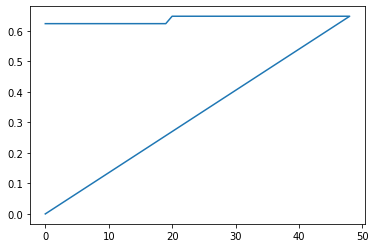

|  49       | -0.5174   |  52.81    |  2.51     |  0.7098   |  0.7899   |  1.278e+0 |  1.011    |  0.8405   |  110.1    |  0.7284   |  0.3617   |  2.407    |  0.7727   |  2.121    |  7.925    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.80678
    weight_decay: 0.15427676305682994
)
Batch Normalization Momentum:  0.4
Nodes:  32
LR:  0.80678
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.15427676305682994
BATCH_SIZE:  96
Dropout:  0.56
Final Linear Layers:  3
average loss: 197.623856
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0439)
Class:  0  correct:  5.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7093)
Class:  1  correct:  61.0  of  tensor(86.)


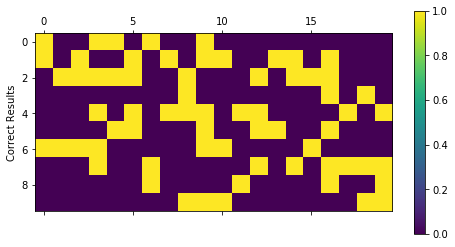

Final percentage:  tensor(0.3766)
Last epoch:  20


Best Score So Far:  tensor(-0.6477)


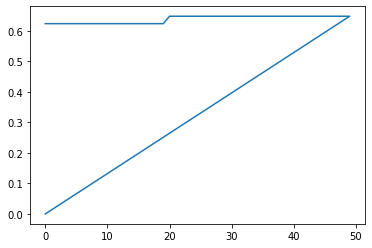

|  50       | -0.3766   |  96.58    |  2.22     |  0.3978   |  0.5578   |  1.003e+0 |  3.317    |  0.8068   |  32.15    |  0.1215   |  0.1543   |  1.601    |  0.8742   |  2.624    |  3.578    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.74532
    rho: 0.9
    weight_decay: 0.47251262620589274
)
Batch Normalization Momentum:  0.61
Nodes:  55
LR:  0.74532
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.47251262620589274
BATCH_SIZE:  19
Dropout:  0.26
Final Linear Layers:  2
average loss: 52.625256
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9825)
Class:  0  correct:  112.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1744)
Class:  1  correct:  15.0  of  tensor(86.)


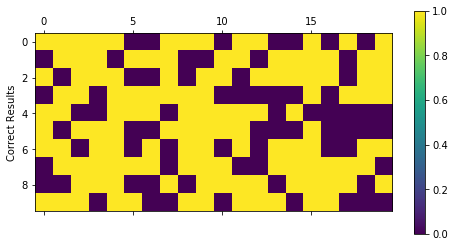

Final percentage:  tensor(0.5784)
Last epoch:  11


Best Score So Far:  tensor(-0.6477)


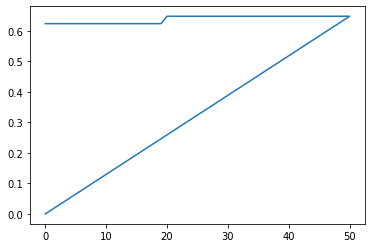

|  51       | -0.5784   |  19.43    |  1.577    |  0.6077   |  0.2593   |  1.457e+0 |  2.328    |  0.7453   |  55.72    |  0.346    |  0.4725   |  1.441    |  0.4626   |  1.941    |  6.635    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.38969
    weight_decay: 0.5367655336072478
)
Batch Normalization Momentum:  0.78
Nodes:  116
LR:  0.38969
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5367655336072478
BATCH_SIZE:  112
Dropout:  0.37
Final Linear Layers:  1
average loss: 142.524231
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0814)
Class:  1  correct:  7.0  of  tensor(86.)


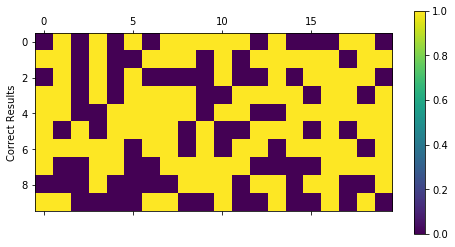

Final percentage:  tensor(0.5363)
Last epoch:  33


Best Score So Far:  tensor(-0.6477)


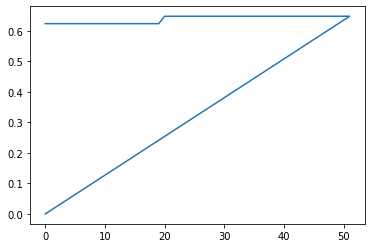

|  52       | -0.5363   |  112.5    |  1.891    |  0.7766   |  0.3656   |  1.656e+0 |  1.394    |  0.3897   |  116.6    |  0.6053   |  0.5368   |  2.004    |  0.4931   |  3.52     |  1.61     |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.63066
    weight_decay: 0.4370732580116328
)
Batch Normalization Momentum:  0.51
Nodes:  70
LR:  0.63066
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.4370732580116328
BATCH_SIZE:  74
Dropout:  0.16
Final Linear Layers:  1
average loss: 44615.570312
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1977)
Class:  1  correct:  17.0  of  tensor(86.)


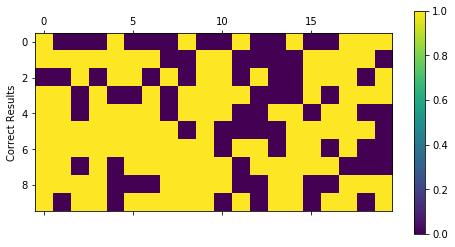

Final percentage:  tensor(0.5813)
Last epoch:  22


Best Score So Far:  tensor(-0.6477)


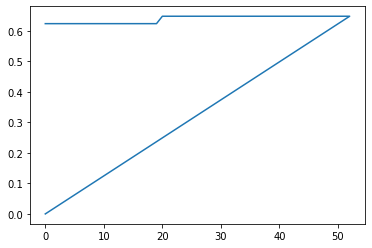

|  53       | -0.5813   |  74.23    |  2.876    |  0.5127   |  0.1556   |  1.848e+0 |  1.752    |  0.6307   |  70.07    |  0.9479   |  0.4371   |  2.668    |  0.007854 |  3.958    |  1.699    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.23018
    weight_decay: 0.09412359219812172
)
Batch Normalization Momentum:  0.01
Nodes:  103
LR:  0.23018
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.09412359219812172
BATCH_SIZE:  42
Dropout:  0.66
Final Linear Layers:  2
average loss: 106.983757
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0814)
Class:  1  correct:  7.0  of  tensor(86.)


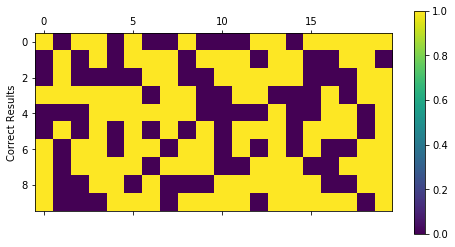

Final percentage:  tensor(0.5407)
Last epoch:  12


Best Score So Far:  tensor(-0.6477)


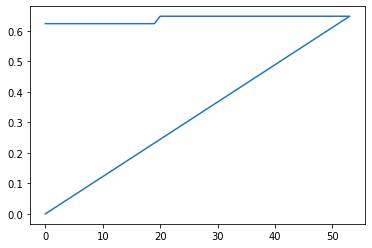

|  54       | -0.5407   |  42.59    |  2.883    |  0.00885  |  0.6582   |  1.861e+0 |  2.315    |  0.2302   |  103.1    |  0.4779   |  0.09412  |  2.846    |  0.887    |  2.47     |  8.702    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.2648
    momentum: 0.56
    nesterov: False
    weight_decay: 0.009963196705290823
)
Batch Normalization Momentum:  0.39
Nodes:  15
LR:  0.2648
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.009963196705290823
BATCH_SIZE:  54
Dropout:  0.4
Final Linear Layers:  3
average loss: 196.925201
average loss: 0.693662
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.1579)
Class:  0  correct:  18.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6279)
Class:  1  correct:  54.0  of  tensor(86.)


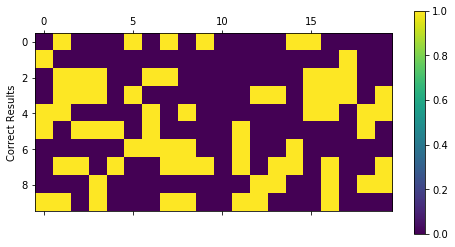

Final percentage:  tensor(0.3929)
Last epoch:  141


Best Score So Far:  tensor(-0.6477)


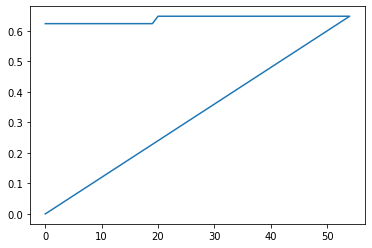

|  55       | -0.3929   |  54.74    |  2.36     |  0.394    |  0.4046   |  1.19e+03 |  3.885    |  0.2648   |  15.04    |  0.145    |  0.009963 |  2.425    |  0.5589   |  3.376    |  5.559    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.28964
    t0: 1000000.0
    weight_decay: 0.16906898170112258
)
Batch Normalization Momentum:  0.77
Nodes:  23
LR:  0.28964
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.16906898170112258
BATCH_SIZE:  101
Dropout:  0.33
Final Linear Layers:  1
average loss: 965.208496
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0702)
Class:  0  correct:  8.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7093)
Class:  1  correct:  61.0  of  tensor(86.)


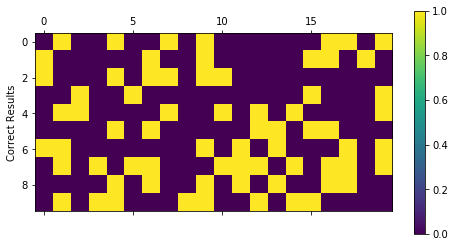

Final percentage:  tensor(0.3897)
Last epoch:  58


Best Score So Far:  tensor(-0.6477)


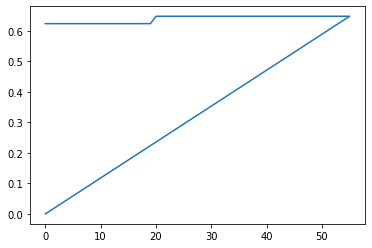

|  56       | -0.3897   |  101.8    |  2.385    |  0.7701   |  0.3252   |  1.648e+0 |  1.538    |  0.2896   |  23.75    |  0.4088   |  0.1691   |  1.81     |  0.9655   |  1.958    |  9.833    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.38965
    momentum: 0.8
    nesterov: False
    weight_decay: 0.48818847604163623
)
Batch Normalization Momentum:  0.85
Nodes:  47
LR:  0.38965
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.48818847604163623
BATCH_SIZE:  82
Dropout:  0.5
Final Linear Layers:  3
average loss: 0.756508
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.5439)
Class:  0  correct:  62.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3372)
Class:  1  correct:  29.0  of  tensor(86.)


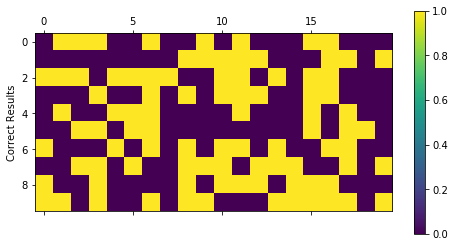

Final percentage:  tensor(0.4405)
Last epoch:  9


Best Score So Far:  tensor(-0.6477)


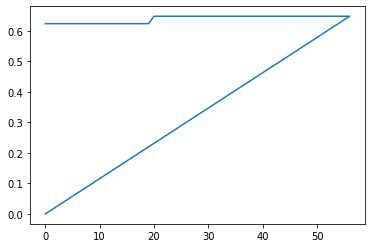

|  57       | -0.4405   |  82.17    |  1.746    |  0.8489   |  0.4957   |  1.252e+0 |  3.371    |  0.3897   |  47.05    |  0.3306   |  0.4882   |  1.535    |  0.8002   |  1.883    |  5.892    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.40151
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.88
Nodes:  118
LR:  0.40151
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4262209388182376
BATCH_SIZE:  63
Dropout:  0.15
Final Linear Layers:  3
average loss: 14.462603
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.1491)
Class:  0  correct:  17.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.8372)
Class:  1  correct:  72.0  of  tensor(86.)


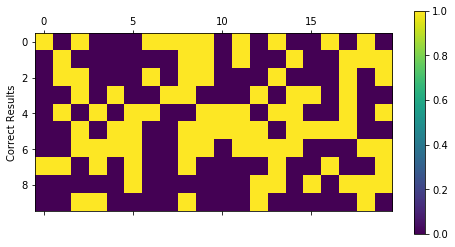

Final percentage:  tensor(0.4932)
Last epoch:  11


Best Score So Far:  tensor(-0.6477)


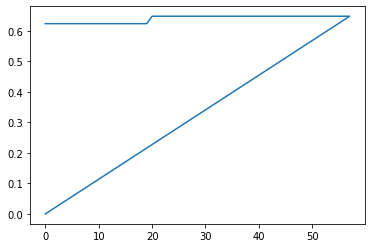

|  58       | -0.4932   |  63.48    |  2.702    |  0.8795   |  0.1475   |  1.585e+0 |  3.686    |  0.4015   |  118.2    |  0.2794   |  0.4262   |  2.358    |  0.2259   |  1.041    |  4.746    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.6451
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.77
Nodes:  90
LR:  0.6451
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.17745188453696112
BATCH_SIZE:  120
Dropout:  0.14
Final Linear Layers:  1
average loss: 7.738460
Class:  0  accuracy:  tensor(0.7982)
Class:  0  correct:  91.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.5814)
Class:  1  correct:  50.0  of  tensor(86.)


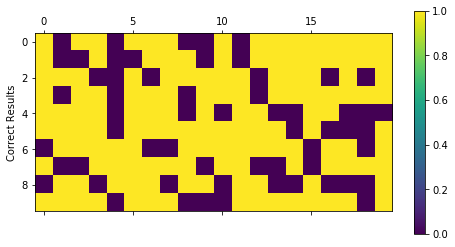

Final percentage:  tensor(0.6898)
Last epoch:  7


Best Score So Far:  tensor(-0.6898)


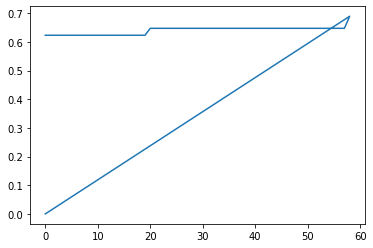

|  59       | -0.6898   |  120.2    |  1.683    |  0.7719   |  0.1398   |  1.342e+0 |  1.432    |  0.6451   |  90.11    |  0.6881   |  0.1775   |  2.378    |  0.225    |  2.27     |  4.344    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.15295
    momentum: 0.46
    nesterov: False
    weight_decay: 0.6127453751755418
)
Batch Normalization Momentum:  0.63
Nodes:  20
LR:  0.15295
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6127453751755418
BATCH_SIZE:  46
Dropout:  0.57
Final Linear Layers:  2
average loss: 8.044971
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9561)
Class:  0  correct:  109.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2442)
Class:  1  correct:  21.0  of  tensor(86.)


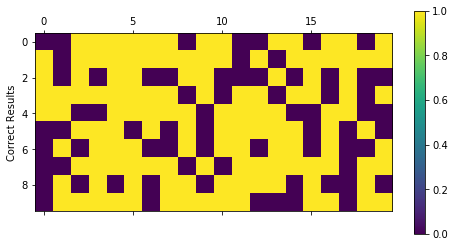

Final percentage:  tensor(0.6002)
Last epoch:  8


Best Score So Far:  tensor(-0.6898)


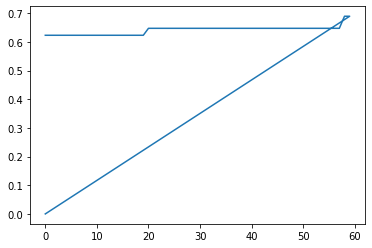

|  60       | -0.6002   |  46.77    |  1.115    |  0.6253   |  0.5659   |  1.614e+0 |  2.938    |  0.153    |  20.83    |  0.5141   |  0.6127   |  1.366    |  0.4582   |  2.283    |  5.471    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.54632
    weight_decay: 0.20793326534225448
)
Batch Normalization Momentum:  0.26
Nodes:  20
LR:  0.54632
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.20793326534225448
BATCH_SIZE:  22
Dropout:  0.68
Final Linear Layers:  2
average loss: 242.415466
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9474)
Class:  0  correct:  108.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1860)
Class:  1  correct:  16.0  of  tensor(86.)


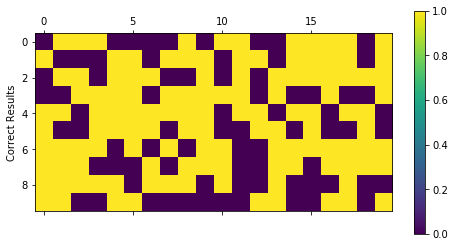

Final percentage:  tensor(0.5667)
Last epoch:  10


Best Score So Far:  tensor(-0.6898)


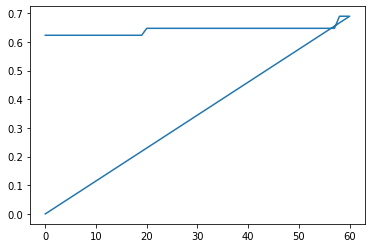

|  61       | -0.5667   |  22.35    |  1.681    |  0.2593   |  0.6756   |  1.8e+03  |  2.276    |  0.5463   |  20.33    |  0.5096   |  0.2079   |  2.711    |  0.6649   |  2.894    |  2.122    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.5091
    t0: 1000000.0
    weight_decay: 0.4195289019850552
)
Batch Normalization Momentum:  0.94
Nodes:  61
LR:  0.5091
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4195289019850552
BATCH_SIZE:  61
Dropout:  0.52
Final Linear Layers:  2
average loss: 14.491842
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0439)
Class:  0  correct:  5.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7558)
Class:  1  correct:  65.0  of  tensor(86.)


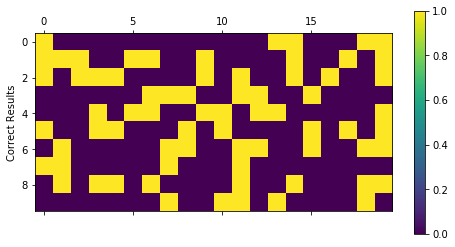

Final percentage:  tensor(0.3998)
Last epoch:  12


Best Score So Far:  tensor(-0.6898)


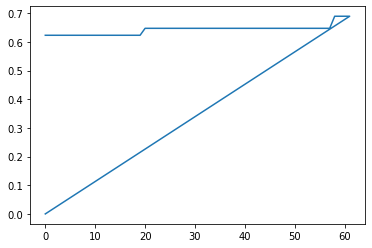

|  62       | -0.3998   |  61.29    |  2.963    |  0.9388   |  0.5161   |  1.152e+0 |  2.911    |  0.5091   |  61.05    |  0.4282   |  0.4195   |  2.691    |  0.7436   |  2.732    |  9.313    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.56131
    weight_decay: 0.042819573115657796
)
Batch Normalization Momentum:  0.05
Nodes:  8
LR:  0.56131
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.042819573115657796
BATCH_SIZE:  10
Dropout:  0.16
Final Linear Layers:  1
average loss: 1.462776
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2326)
Class:  1  correct:  20.0  of  tensor(86.)


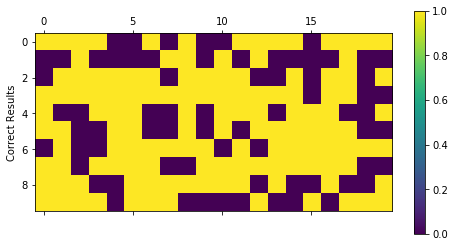

Final percentage:  tensor(0.5987)
Last epoch:  10


Best Score So Far:  tensor(-0.6898)


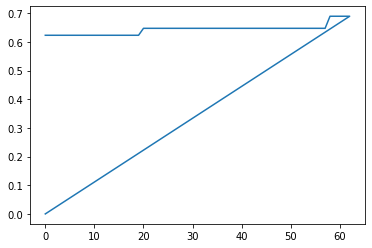

|  63       | -0.5987   |  10.16    |  2.973    |  0.05246  |  0.1596   |  1.423e+0 |  1.321    |  0.5613   |  8.047    |  0.2851   |  0.04282  |  2.4      |  0.6618   |  2.132    |  2.692    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.57981
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.79
Nodes:  46
LR:  0.57981
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.3037749750105692
BATCH_SIZE:  96
Dropout:  0.39
Final Linear Layers:  1
average loss: 221.267441
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0233)
Class:  1  correct:  2.0  of  tensor(86.)


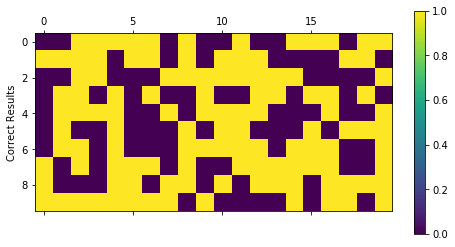

Final percentage:  tensor(0.5116)
Last epoch:  9


Best Score So Far:  tensor(-0.6898)


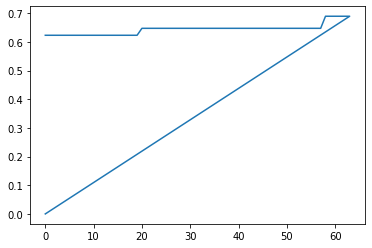

|  64       | -0.5116   |  96.12    |  1.677    |  0.7873   |  0.3903   |  1.526e+0 |  1.085    |  0.5798   |  46.18    |  0.2297   |  0.3038   |  1.761    |  0.4651   |  3.929    |  4.276    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.03919
    weight_decay: 0.2635166153592925
)
Batch Normalization Momentum:  0.88
Nodes:  121
LR:  0.03919
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.2635166153592925
BATCH_SIZE:  99
Dropout:  0.28
Final Linear Layers:  3
average loss: 124.802559
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2093)
Class:  1  correct:  18.0  of  tensor(86.)


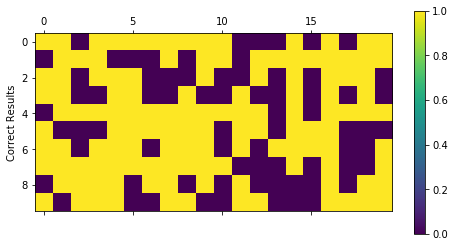

Final percentage:  tensor(0.5871)
Last epoch:  17


Best Score So Far:  tensor(-0.6898)


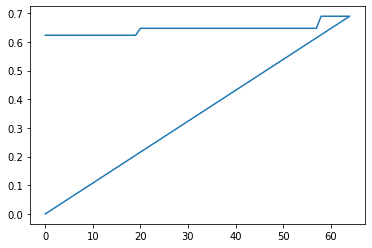

|  65       | -0.5871   |  99.58    |  2.1      |  0.8802   |  0.284    |  1.246e+0 |  3.724    |  0.03919  |  121.8    |  0.5563   |  0.2635   |  2.98     |  0.05778  |  2.545    |  1.28     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.63762
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.62
Nodes:  99
LR:  0.63762
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.3700205897752778
BATCH_SIZE:  73
Dropout:  0.78
Final Linear Layers:  2
average loss: 25.418131
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0814)
Class:  1  correct:  7.0  of  tensor(86.)


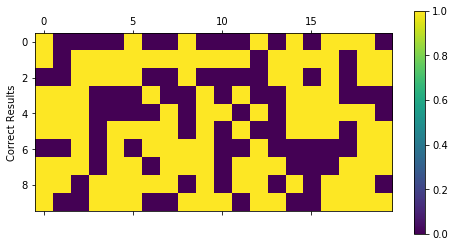

Final percentage:  tensor(0.5363)
Last epoch:  10


Best Score So Far:  tensor(-0.6898)


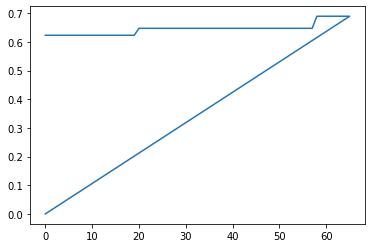

|  66       | -0.5363   |  73.97    |  1.359    |  0.6246   |  0.7847   |  1.875e+0 |  2.351    |  0.6376   |  99.96    |  0.4949   |  0.37     |  1.3      |  0.3657   |  1.425    |  7.535    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.06482
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.88
Nodes:  54
LR:  0.06482
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.20387864299264438
BATCH_SIZE:  62
Dropout:  0.42
Final Linear Layers:  1
average loss: 102.801308
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0088)
Class:  0  correct:  1.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9767)
Class:  1  correct:  84.0  of  tensor(86.)


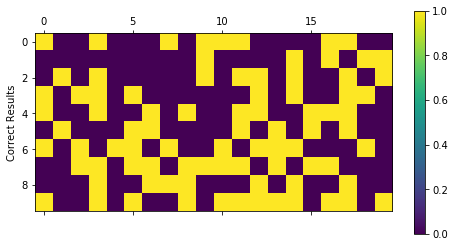

Final percentage:  tensor(0.4928)
Last epoch:  8


Best Score So Far:  tensor(-0.6898)


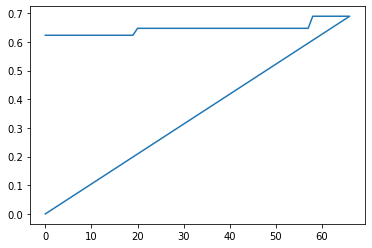

|  67       | -0.4928   |  62.1     |  1.893    |  0.8771   |  0.4221   |  1.409e+0 |  1.804    |  0.06482  |  54.69    |  0.0267   |  0.2039   |  2.002    |  0.9563   |  1.327    |  7.051    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.17252
    rho: 0.9
    weight_decay: 0.15190235217949552
)
Batch Normalization Momentum:  0.14
Nodes:  98
LR:  0.17252
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.15190235217949552
BATCH_SIZE:  64
Dropout:  0.07
Final Linear Layers:  3
average loss: 39.319839
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0526)
Class:  0  correct:  6.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7209)
Class:  1  correct:  62.0  of  tensor(86.)


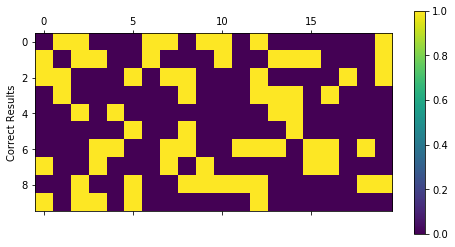

Final percentage:  tensor(0.3868)
Last epoch:  91


Best Score So Far:  tensor(-0.6898)


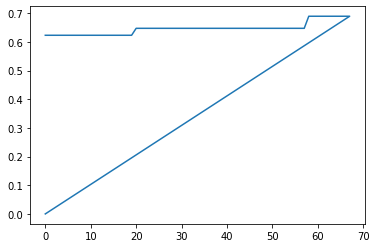

|  68       | -0.3868   |  64.99    |  2.546    |  0.1422   |  0.06656  |  1.399e+0 |  3.383    |  0.1725   |  98.74    |  0.2907   |  0.1519   |  1.033    |  0.3947   |  2.139    |  6.928    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.28893
    weight_decay: 0.5841571111612189
)
Batch Normalization Momentum:  0.02
Nodes:  72
LR:  0.28893
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5841571111612189
BATCH_SIZE:  10
Dropout:  0.09
Final Linear Layers:  2
average loss: 1.428183
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9211)
Class:  0  correct:  105.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2791)
Class:  1  correct:  24.0  of  tensor(86.)


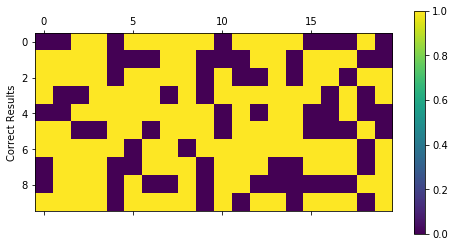

Final percentage:  tensor(0.6001)
Last epoch:  9


Best Score So Far:  tensor(-0.6898)


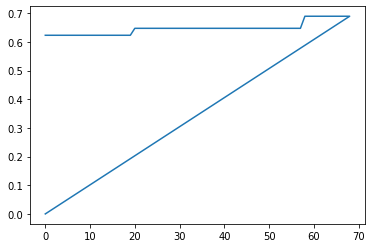

|  69       | -0.6001   |  10.94    |  1.304    |  0.01641  |  0.09104  |  1.652e+0 |  2.204    |  0.2889   |  72.3     |  0.9925   |  0.5842   |  2.392    |  0.9091   |  1.119    |  1.632    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.40198
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.93
Nodes:  112
LR:  0.40198
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.19173941194026017
BATCH_SIZE:  61
Dropout:  0.39
Final Linear Layers:  3
average loss: 645.139404
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9419)
Class:  1  correct:  81.0  of  tensor(86.)


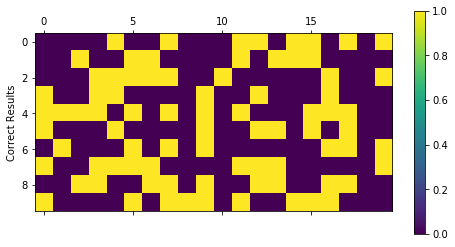

Final percentage:  tensor(0.4709)
Last epoch:  11


Best Score So Far:  tensor(-0.6898)


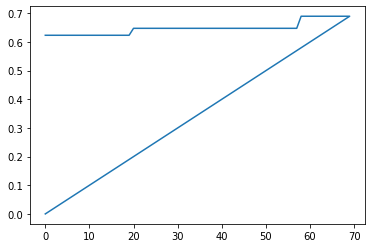

|  70       | -0.4709   |  61.72    |  1.695    |  0.9279   |  0.3917   |  1.54e+03 |  3.677    |  0.402    |  112.5    |  0.2541   |  0.1917   |  1.653    |  0.5421   |  1.658    |  7.036    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.47323
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.86
Nodes:  11
LR:  0.47323
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6657998193312425
BATCH_SIZE:  19
Dropout:  0.19
Final Linear Layers:  2
average loss: 15.584720
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8684)
Class:  0  correct:  99.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2674)
Class:  1  correct:  23.0  of  tensor(86.)


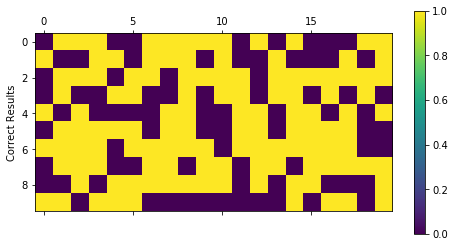

Final percentage:  tensor(0.5679)
Last epoch:  13


Best Score So Far:  tensor(-0.6898)


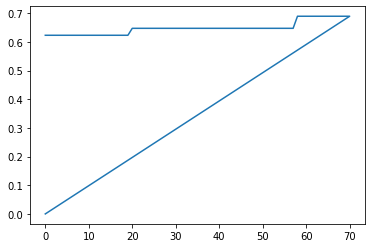

|  71       | -0.5679   |  19.99    |  1.187    |  0.8615   |  0.1895   |  1.386e+0 |  2.709    |  0.4732   |  11.58    |  0.8734   |  0.6658   |  2.617    |  0.281    |  2.578    |  4.051    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.29324
    weight_decay: 0.533866203602033
)
Batch Normalization Momentum:  0.31
Nodes:  114
LR:  0.29324
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.533866203602033
BATCH_SIZE:  71
Dropout:  0.54
Final Linear Layers:  3
average loss: 4.882501
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0351)
Class:  0  correct:  4.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7442)
Class:  1  correct:  64.0  of  tensor(86.)


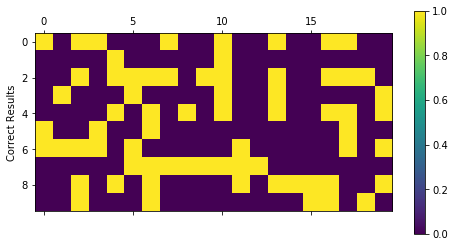

Final percentage:  tensor(0.3896)
Last epoch:  13


Best Score So Far:  tensor(-0.6898)


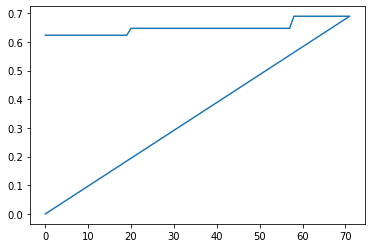

|  72       | -0.3896   |  71.89    |  2.939    |  0.3086   |  0.535    |  1.326e+0 |  3.316    |  0.2932   |  114.1    |  0.7512   |  0.5339   |  1.934    |  0.2087   |  1.124    |  3.893    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.03588
    rho: 0.9
    weight_decay: 0.23503109443513837
)
Batch Normalization Momentum:  0.66
Nodes:  18
LR:  0.03588
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.23503109443513837
BATCH_SIZE:  6
Dropout:  0.34
Final Linear Layers:  2
average loss: 101.477692
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3772)
Class:  0  correct:  43.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.4302)
Class:  1  correct:  37.0  of  tensor(86.)


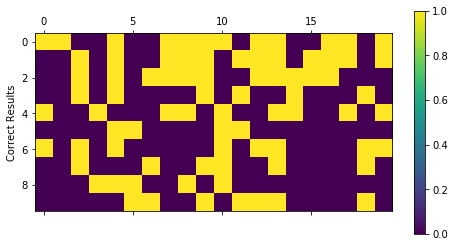

Final percentage:  tensor(0.4037)
Last epoch:  34


Best Score So Far:  tensor(-0.6898)


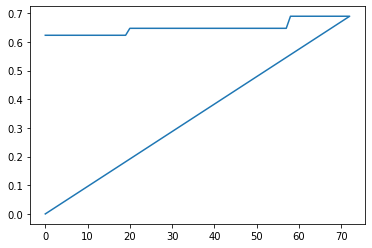

|  73       | -0.4037   |  6.676    |  2.381    |  0.6636   |  0.3444   |  1.768e+0 |  2.603    |  0.03588  |  18.98    |  0.194    |  0.235    |  1.104    |  0.5991   |  2.531    |  6.551    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.7407
    weight_decay: 0.16462679767730107
)
Batch Normalization Momentum:  0.45
Nodes:  121
LR:  0.7407
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.16462679767730107
BATCH_SIZE:  56
Dropout:  0.01
Final Linear Layers:  2
average loss: 28356.326172
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1395)
Class:  1  correct:  12.0  of  tensor(86.)


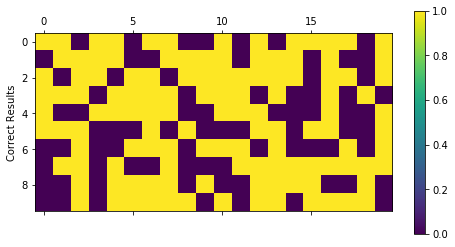

Final percentage:  tensor(0.5522)
Last epoch:  22


Best Score So Far:  tensor(-0.6898)


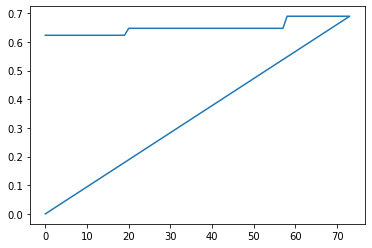

|  74       | -0.5522   |  56.48    |  2.687    |  0.4495   |  0.01232  |  1.873e+0 |  2.962    |  0.7407   |  121.9    |  0.05181  |  0.1646   |  1.126    |  0.4174   |  3.583    |  1.734    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.21548
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.77
Nodes:  122
LR:  0.21548
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.42979240826905213
BATCH_SIZE:  61
Dropout:  0.67
Final Linear Layers:  2
average loss: 552.372681
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(86.)


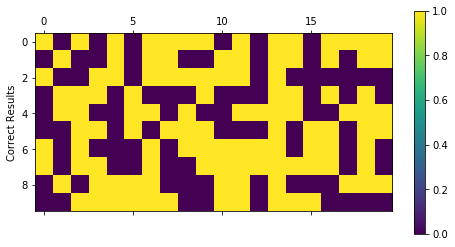

Final percentage:  tensor(0.5000)
Last epoch:  13


Best Score So Far:  tensor(-0.6898)


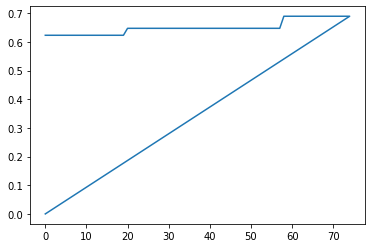

|  75       | -0.5      |  61.61    |  1.25     |  0.7652   |  0.6731   |  1.043e+0 |  2.454    |  0.2155   |  122.0    |  0.943    |  0.4298   |  2.937    |  0.3414   |  3.685    |  4.907    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.54444
    weight_decay: 0.4203822197966536
)
Batch Normalization Momentum:  0.68
Nodes:  94
LR:  0.54444
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.4203822197966536
BATCH_SIZE:  31
Dropout:  0.05
Final Linear Layers:  3
average loss: 1.628933
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9737)
Class:  0  correct:  111.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1512)
Class:  1  correct:  13.0  of  tensor(86.)


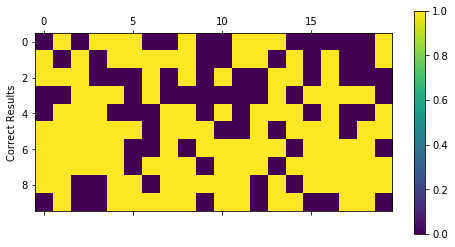

Final percentage:  tensor(0.5624)
Last epoch:  13


Best Score So Far:  tensor(-0.6898)


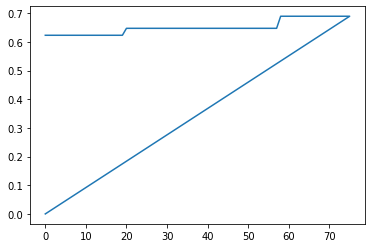

|  76       | -0.5624   |  31.71    |  2.872    |  0.6774   |  0.05193  |  1.87e+03 |  3.097    |  0.5444   |  94.28    |  0.2539   |  0.4204   |  2.621    |  0.05357  |  1.39     |  8.574    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  SGD (
Parameter Group 0
    dampening: 0
    lr: 0.058
    momentum: 0.48
    nesterov: False
    weight_decay: 0.5783766520911247
)
Batch Normalization Momentum:  0.25
Nodes:  115
LR:  0.058
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.5783766520911247
BATCH_SIZE:  79
Dropout:  0.24
Final Linear Layers:  2
average loss: 150.189087
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0877)
Class:  0  correct:  10.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7442)
Class:  1  correct:  64.0  of  tensor(86.)


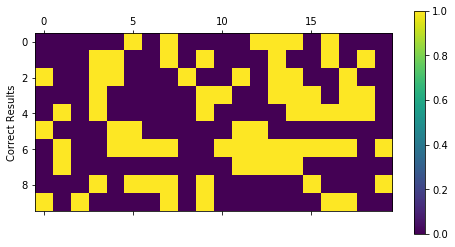

Final percentage:  tensor(0.4160)
Last epoch:  30


Best Score So Far:  tensor(-0.6898)


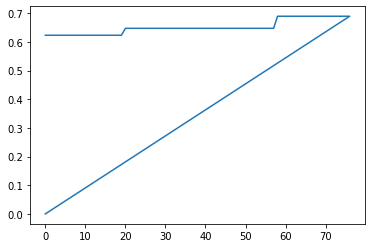

|  77       | -0.416    |  79.91    |  2.057    |  0.2458   |  0.2361   |  1.873e+0 |  2.261    |  0.058    |  115.0    |  0.204    |  0.5784   |  2.755    |  0.4819   |  2.789    |  5.74     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.20431
    t0: 1000000.0
    weight_decay: 0.09207782081016865
)
Batch Normalization Momentum:  0.28
Nodes:  77
LR:  0.20431
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.09207782081016865
BATCH_SIZE:  80
Dropout:  0.71
Final Linear Layers:  1
average loss: 245.032867
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0702)
Class:  0  correct:  8.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7326)
Class:  1  correct:  63.0  of  tensor(86.)


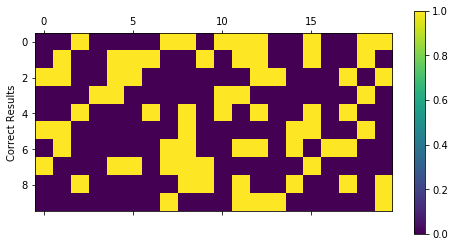

Final percentage:  tensor(0.4014)
Last epoch:  96


Best Score So Far:  tensor(-0.6898)


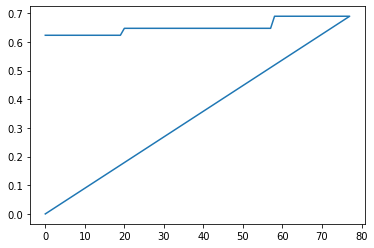

|  78       | -0.4014   |  80.73    |  2.702    |  0.2793   |  0.707    |  1.568e+0 |  1.344    |  0.2043   |  77.09    |  0.24     |  0.09208  |  1.322    |  0.8364   |  2.801    |  9.662    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.85339
    rho: 0.9
    weight_decay: 0.5270728478944615
)
Batch Normalization Momentum:  0.59
Nodes:  69
LR:  0.85339
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5270728478944615
BATCH_SIZE:  45
Dropout:  0.49
Final Linear Layers:  3
average loss: 284.971222
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1163)
Class:  1  correct:  10.0  of  tensor(86.)


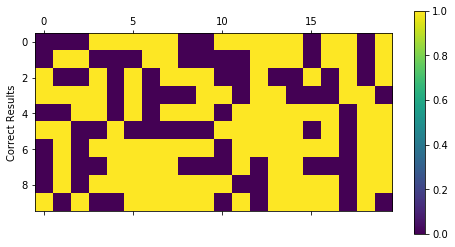

Final percentage:  tensor(0.5538)
Last epoch:  16


Best Score So Far:  tensor(-0.6898)


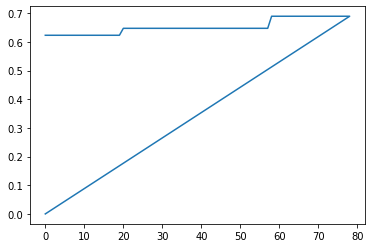

|  79       | -0.5538   |  45.56    |  2.185    |  0.593    |  0.4926   |  1.059e+0 |  3.243    |  0.8534   |  69.37    |  0.1932   |  0.5271   |  1.015    |  0.325    |  3.744    |  6.289    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.64918
    weight_decay: 0.41291757131211143
)
Batch Normalization Momentum:  0.81
Nodes:  57
LR:  0.64918
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.41291757131211143
BATCH_SIZE:  109
Dropout:  0.7
Final Linear Layers:  1
average loss: 144.904236
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.7456)
Class:  0  correct:  85.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.5581)
Class:  1  correct:  48.0  of  tensor(86.)


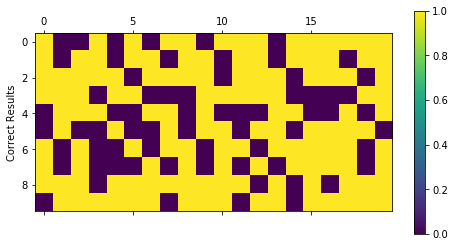

Final percentage:  tensor(0.6519)
Last epoch:  23


Best Score So Far:  tensor(-0.6898)


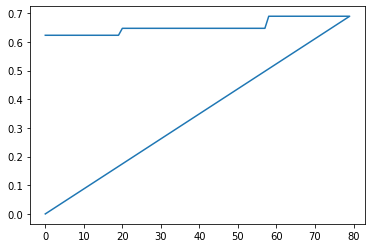

|  80       | -0.6519   |  109.8    |  2.203    |  0.8144   |  0.7036   |  1.321e+0 |  1.368    |  0.6492   |  57.48    |  0.1275   |  0.4129   |  1.072    |  0.1982   |  3.357    |  1.109    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.45641
    rho: 0.9
    weight_decay: 0.18496993718297766
)
Batch Normalization Momentum:  0.99
Nodes:  59
LR:  0.45641
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.18496993718297766
BATCH_SIZE:  40
Dropout:  0.47
Final Linear Layers:  3
average loss: 218.502289
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9737)
Class:  0  correct:  111.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1977)
Class:  1  correct:  17.0  of  tensor(86.)


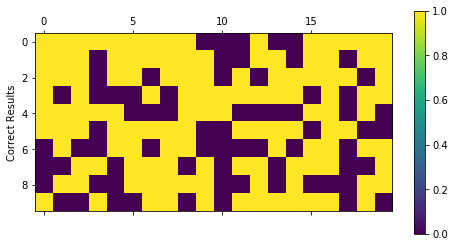

Final percentage:  tensor(0.5857)
Last epoch:  22


Best Score So Far:  tensor(-0.6898)


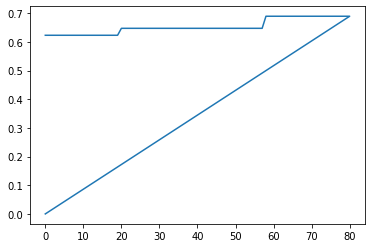

|  81       | -0.5857   |  40.22    |  1.043    |  0.9875   |  0.4656   |  1.293e+0 |  3.778    |  0.4564   |  59.29    |  0.5877   |  0.185    |  1.608    |  0.3679   |  1.731    |  6.255    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.07206
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.96
Nodes:  62
LR:  0.07206
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.47076360810239837
BATCH_SIZE:  89
Dropout:  0.6
Final Linear Layers:  3
average loss: 5.104884
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8684)
Class:  0  correct:  99.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.4419)
Class:  1  correct:  38.0  of  tensor(86.)


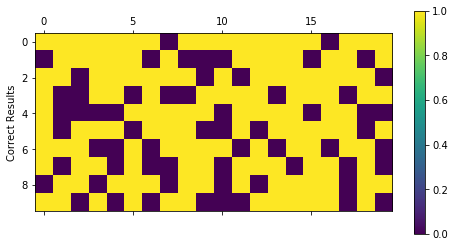

Final percentage:  tensor(0.6551)
Last epoch:  9


Best Score So Far:  tensor(-0.6898)


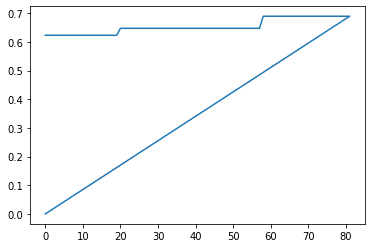

|  82       | -0.6551   |  89.68    |  1.143    |  0.9614   |  0.6025   |  1.806e+0 |  3.247    |  0.07206  |  62.69    |  0.4458   |  0.4708   |  1.893    |  0.6973   |  3.038    |  7.267    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.15902
    weight_decay: 0.5708523026110377
)
Batch Normalization Momentum:  0.75
Nodes:  51
LR:  0.15902
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5708523026110377
BATCH_SIZE:  79
Dropout:  0.62
Final Linear Layers:  1
average loss: 142.025558
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9123)
Class:  0  correct:  104.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3256)
Class:  1  correct:  28.0  of  tensor(86.)


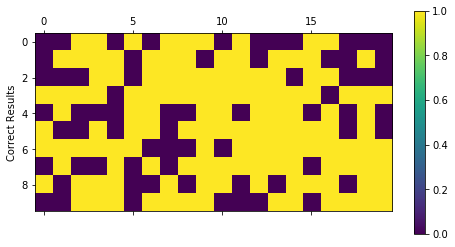

Final percentage:  tensor(0.6189)
Last epoch:  21


Best Score So Far:  tensor(-0.6898)


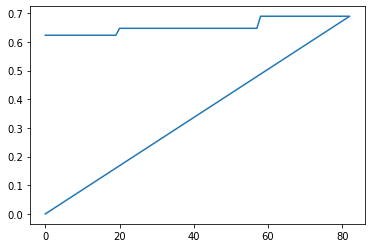

|  83       | -0.6189   |  79.94    |  1.3      |  0.7532   |  0.6248   |  1.904e+0 |  1.699    |  0.159    |  51.28    |  0.3209   |  0.5709   |  2.221    |  0.7524   |  2.279    |  1.894    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.442
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.19
Nodes:  13
LR:  0.442
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.32317529641604625
BATCH_SIZE:  16
Dropout:  0.66
Final Linear Layers:  3
average loss: 605.007263
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9535)
Class:  1  correct:  82.0  of  tensor(86.)


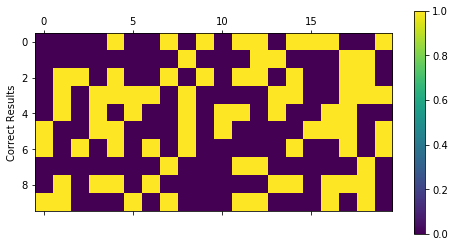

Final percentage:  tensor(0.4767)
Last epoch:  8


Best Score So Far:  tensor(-0.6898)


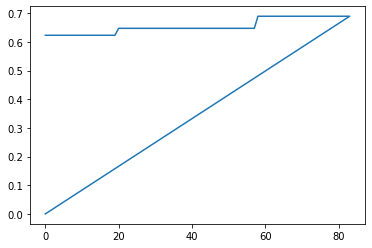

|  84       | -0.4767   |  16.49    |  1.743    |  0.1919   |  0.6566   |  1.6e+03  |  3.06     |  0.442    |  13.11    |  0.2356   |  0.3232   |  1.395    |  0.02522  |  3.181    |  7.517    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.18066
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.42
Nodes:  68
LR:  0.18066
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.21356528368706768
BATCH_SIZE:  43
Dropout:  0.69
Final Linear Layers:  2
average loss: 117.348869
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0088)
Class:  0  correct:  1.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.8605)
Class:  1  correct:  74.0  of  tensor(86.)


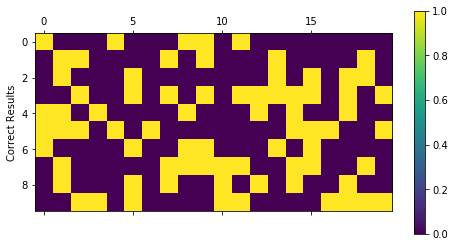

Final percentage:  tensor(0.4346)
Last epoch:  16


Best Score So Far:  tensor(-0.6898)


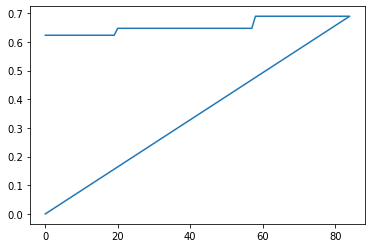

|  85       | -0.4346   |  43.63    |  2.679    |  0.4242   |  0.6917   |  1.657e+0 |  2.737    |  0.1807   |  68.72    |  0.8936   |  0.2136   |  2.733    |  0.8997   |  1.986    |  7.141    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.30991
    rho: 0.9
    weight_decay: 0.5934668517959476
)
Batch Normalization Momentum:  0.87
Nodes:  21
LR:  0.30991
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5934668517959476
BATCH_SIZE:  115
Dropout:  0.15
Final Linear Layers:  2
average loss: 20.379091
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0439)
Class:  0  correct:  5.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.8721)
Class:  1  correct:  75.0  of  tensor(86.)


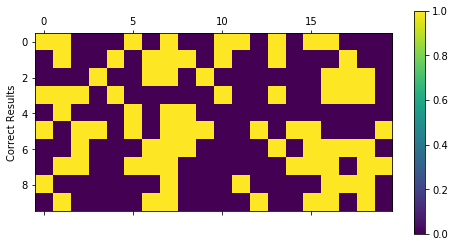

Final percentage:  tensor(0.4580)
Last epoch:  42


Best Score So Far:  tensor(-0.6898)


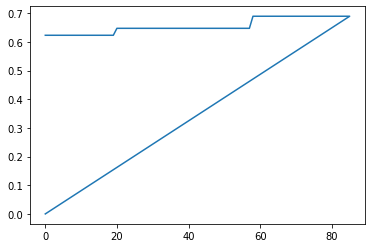

|  86       | -0.458    |  115.3    |  1.151    |  0.8698   |  0.1527   |  1.85e+03 |  2.995    |  0.3099   |  21.07    |  0.6351   |  0.5935   |  2.635    |  0.622    |  3.859    |  6.303    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.46693
    t0: 1000000.0
    weight_decay: 0.25927695507234394
)
Batch Normalization Momentum:  0.33
Nodes:  23
LR:  0.46693
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.25927695507234394
BATCH_SIZE:  26
Dropout:  0.79
Final Linear Layers:  3
average loss: 3.000510
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0526)
Class:  0  correct:  6.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6977)
Class:  1  correct:  60.0  of  tensor(86.)


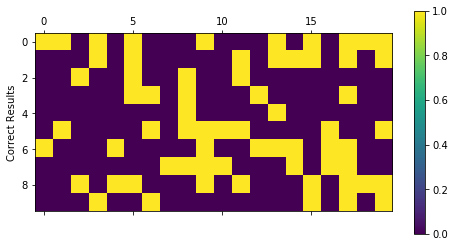

Final percentage:  tensor(0.3752)
Last epoch:  10


Best Score So Far:  tensor(-0.6898)


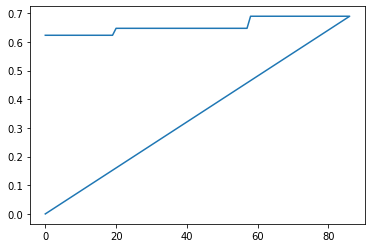

|  87       | -0.3752   |  26.93    |  1.854    |  0.3334   |  0.7936   |  1.38e+03 |  3.968    |  0.4669   |  23.71    |  0.07542  |  0.2593   |  1.246    |  0.6282   |  2.238    |  9.908    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.43848
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.39
Nodes:  54
LR:  0.43848
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6375732167468222
BATCH_SIZE:  119
Dropout:  0.37
Final Linear Layers:  3
average loss: 839.713501
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9767)
Class:  1  correct:  84.0  of  tensor(86.)


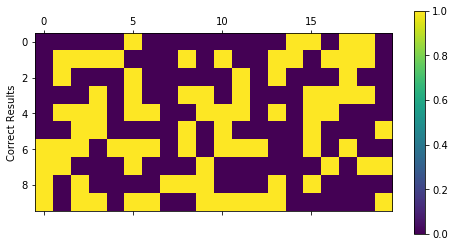

Final percentage:  tensor(0.4884)
Last epoch:  11


Best Score So Far:  tensor(-0.6898)


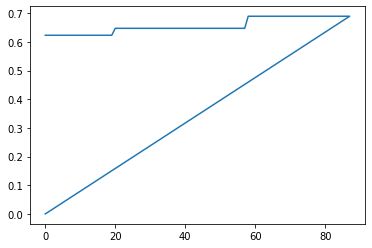

|  88       | -0.4884   |  119.2    |  1.297    |  0.3909   |  0.3693   |  1.561e+0 |  3.333    |  0.4385   |  54.92    |  0.2625   |  0.6376   |  1.044    |  0.8129   |  1.564    |  7.165    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.27833
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.12
Nodes:  2
LR:  0.27833
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.10186800355644786
BATCH_SIZE:  46
Dropout:  0.15
Final Linear Layers:  2
average loss: 176.160385
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0581)
Class:  1  correct:  5.0  of  tensor(86.)


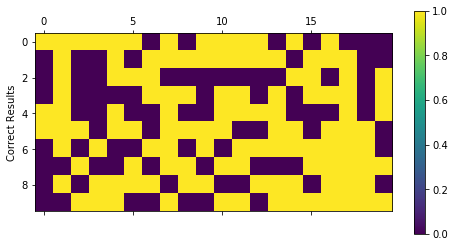

Final percentage:  tensor(0.5291)
Last epoch:  16


Best Score So Far:  tensor(-0.6898)


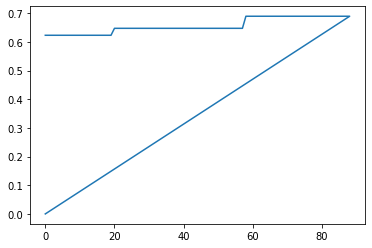

|  89       | -0.5291   |  46.76    |  2.939    |  0.1215   |  0.1501   |  1.889e+0 |  2.744    |  0.2783   |  2.096    |  0.2281   |  0.1019   |  1.405    |  0.8874   |  3.611    |  7.296    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.3483
    weight_decay: 0.6194880665347605
)
Batch Normalization Momentum:  0.49
Nodes:  64
LR:  0.3483
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.6194880665347605
BATCH_SIZE:  61
Dropout:  0.29
Final Linear Layers:  3
average loss: 2005.630371
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9474)
Class:  0  correct:  108.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2791)
Class:  1  correct:  24.0  of  tensor(86.)


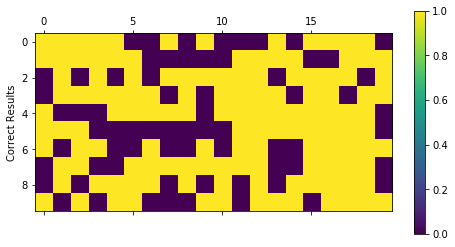

Final percentage:  tensor(0.6132)
Last epoch:  19


Best Score So Far:  tensor(-0.6898)


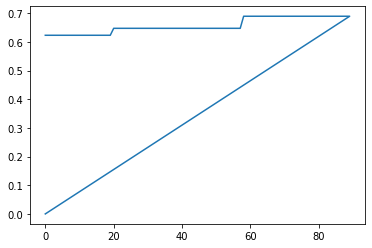

|  90       | -0.6132   |  61.28    |  2.646    |  0.4909   |  0.2908   |  1.276e+0 |  3.765    |  0.3483   |  64.1     |  0.2549   |  0.6195   |  1.763    |  0.2946   |  3.146    |  2.716    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.57452
    rho: 0.9
    weight_decay: 0.6163889644352722
)
Batch Normalization Momentum:  0.74
Nodes:  43
LR:  0.57452
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.6163889644352722
BATCH_SIZE:  16
Dropout:  0.47
Final Linear Layers:  2
average loss: 77.169548
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9474)
Class:  0  correct:  108.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2558)
Class:  1  correct:  22.0  of  tensor(86.)


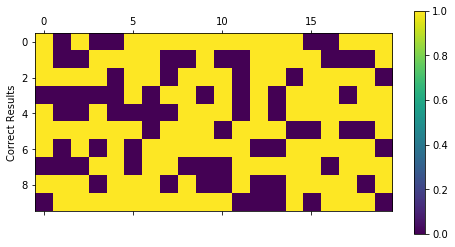

Final percentage:  tensor(0.6016)
Last epoch:  12


Best Score So Far:  tensor(-0.6898)


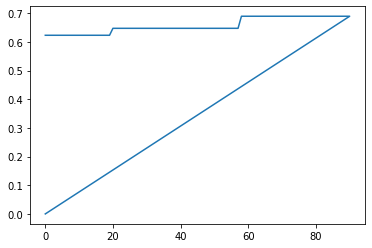

|  91       | -0.6016   |  16.89    |  2.666    |  0.7367   |  0.4724   |  1.243e+0 |  2.864    |  0.5745   |  43.27    |  0.06835  |  0.6164   |  1.915    |  0.7562   |  1.759    |  6.317    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.66754
    weight_decay: 0.005967317359569609
)
Batch Normalization Momentum:  0.13
Nodes:  79
LR:  0.66754
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.005967317359569609
BATCH_SIZE:  56
Dropout:  0.2
Final Linear Layers:  1
average loss: 1750.254883
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9474)
Class:  0  correct:  108.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1977)
Class:  1  correct:  17.0  of  tensor(86.)


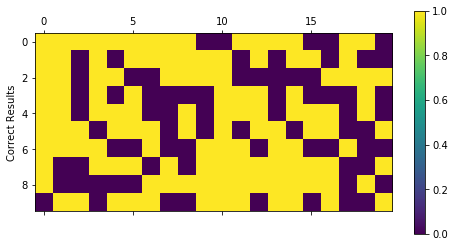

Final percentage:  tensor(0.5725)
Last epoch:  20


Best Score So Far:  tensor(-0.6898)


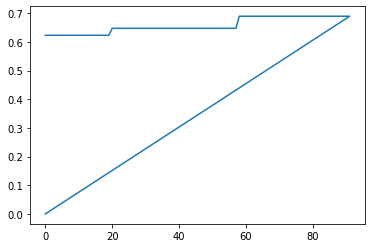

|  92       | -0.5725   |  56.03    |  1.76     |  0.1254   |  0.1954   |  1.079e+0 |  1.906    |  0.6675   |  79.49    |  0.6721   |  0.005967 |  2.35     |  0.4981   |  1.69     |  2.572    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.49181
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.97
Nodes:  104
LR:  0.49181
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4130069136797526
BATCH_SIZE:  25
Dropout:  0.73
Final Linear Layers:  3
average loss: 220.714508
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9651)
Class:  1  correct:  83.0  of  tensor(86.)


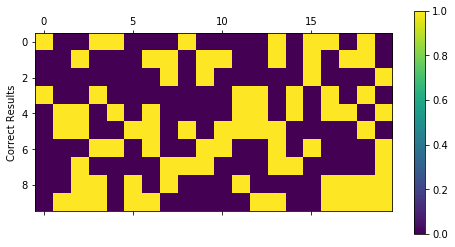

Final percentage:  tensor(0.4826)
Last epoch:  12


Best Score So Far:  tensor(-0.6898)


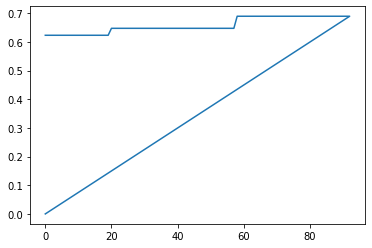

|  93       | -0.4826   |  25.31    |  2.68     |  0.9728   |  0.731    |  1.347e+0 |  3.333    |  0.4918   |  104.9    |  0.4838   |  0.413    |  2.567    |  0.09923  |  2.606    |  4.29     |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.3545
    t0: 1000000.0
    weight_decay: 0.09536559665826065
)
Batch Normalization Momentum:  0.39
Nodes:  88
LR:  0.3545
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.09536559665826065
BATCH_SIZE:  78
Dropout:  0.31
Final Linear Layers:  2
average loss: 285.699646
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0698)
Class:  1  correct:  6.0  of  tensor(86.)


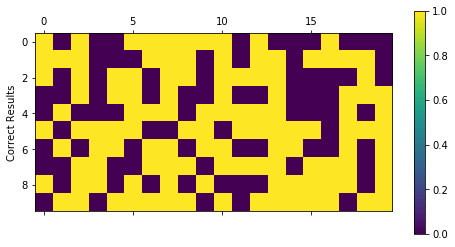

Final percentage:  tensor(0.5349)
Last epoch:  28


Best Score So Far:  tensor(-0.6898)


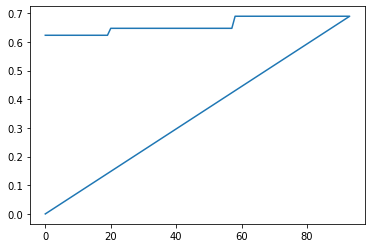

|  94       | -0.5349   |  78.14    |  2.908    |  0.3889   |  0.3144   |  1.791e+0 |  2.929    |  0.3545   |  88.81    |  0.4042   |  0.09537  |  1.897    |  0.3311   |  1.652    |  9.323    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.77636
    weight_decay: 0.050220034581319
)
Batch Normalization Momentum:  0.74
Nodes:  23
LR:  0.77636
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.050220034581319
BATCH_SIZE:  88
Dropout:  0.43
Final Linear Layers:  3
average loss: 775.716919
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9211)
Class:  0  correct:  105.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1279)
Class:  1  correct:  11.0  of  tensor(86.)


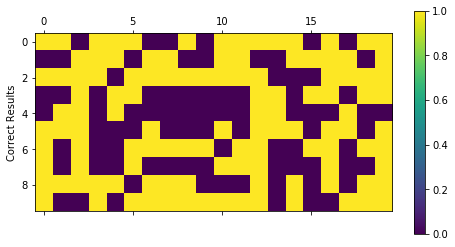

Final percentage:  tensor(0.5245)
Last epoch:  27


Best Score So Far:  tensor(-0.6898)


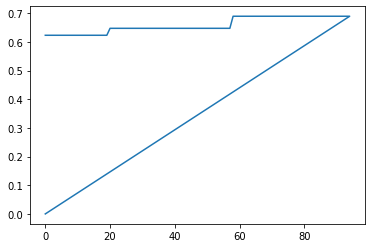

|  95       | -0.5245   |  88.89    |  2.192    |  0.7392   |  0.4336   |  1.701e+0 |  3.782    |  0.7764   |  23.1     |  0.2636   |  0.05022  |  2.948    |  0.234    |  2.975    |  1.806    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.50031
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.1
Nodes:  69
LR:  0.50031
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.4874194311624619
BATCH_SIZE:  28
Dropout:  0.31
Final Linear Layers:  2
average loss: 1029.117065
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9767)
Class:  1  correct:  84.0  of  tensor(86.)


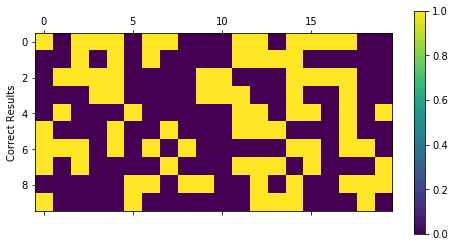

Final percentage:  tensor(0.4884)
Last epoch:  7


Best Score So Far:  tensor(-0.6898)


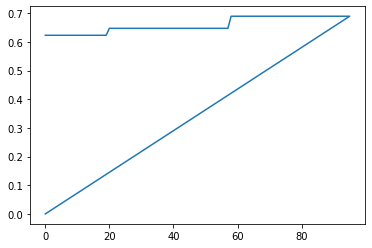

|  96       | -0.4884   |  28.56    |  2.001    |  0.1039   |  0.3111   |  1.538e+0 |  2.014    |  0.5003   |  69.63    |  0.3908   |  0.4874   |  2.35     |  0.6804   |  2.679    |  4.219    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.03385
    weight_decay: 0.0038210414194761555
)
Batch Normalization Momentum:  0.59
Nodes:  98
LR:  0.03385
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.0038210414194761555
BATCH_SIZE:  79
Dropout:  0.78
Final Linear Layers:  3
average loss: 8.109431
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1628)
Class:  1  correct:  14.0  of  tensor(86.)


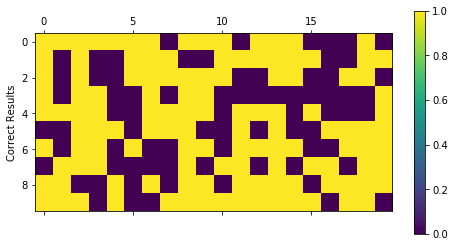

Final percentage:  tensor(0.5639)
Last epoch:  17


Best Score So Far:  tensor(-0.6898)


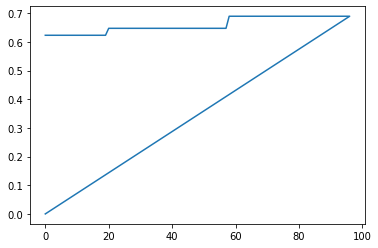

|  97       | -0.5639   |  79.25    |  2.862    |  0.5909   |  0.7837   |  1.441e+0 |  3.211    |  0.03385  |  98.36    |  0.5182   |  0.003821 |  1.552    |  0.5295   |  3.296    |  1.477    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: True
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.82731
    weight_decay: 0.5830944038715655
)
Batch Normalization Momentum:  0.64
Nodes:  98
LR:  0.82731
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5830944038715655
BATCH_SIZE:  71
Dropout:  0.75
Final Linear Layers:  1
average loss: 102668.554688
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.6140)
Class:  0  correct:  70.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.5930)
Class:  1  correct:  51.0  of  tensor(86.)


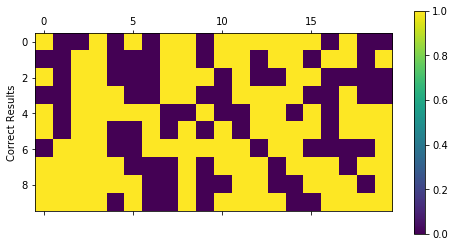

Final percentage:  tensor(0.6035)
Last epoch:  9


Best Score So Far:  tensor(-0.6898)


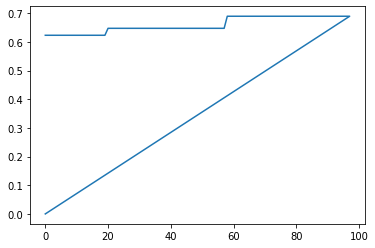

|  98       | -0.6035   |  71.18    |  2.594    |  0.6431   |  0.7452   |  1.075e+0 |  1.828    |  0.8273   |  98.39    |  0.5995   |  0.5831   |  2.783    |  0.963    |  3.986    |  2.255    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.61666
    weight_decay: 0.2476180861681968
)
Batch Normalization Momentum:  0.01
Nodes:  63
LR:  0.61666
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.2476180861681968
BATCH_SIZE:  10
Dropout:  0.78
Final Linear Layers:  3
average loss: 32.651131
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9386)
Class:  0  correct:  107.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3140)
Class:  1  correct:  27.0  of  tensor(86.)


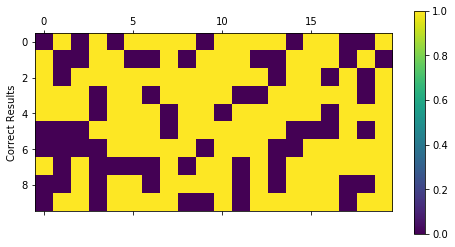

Final percentage:  tensor(0.6263)
Last epoch:  9


Best Score So Far:  tensor(-0.6898)


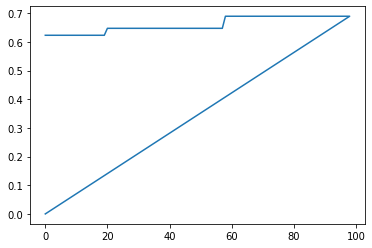

|  99       | -0.6263   |  10.89    |  1.146    |  0.0146   |  0.7775   |  1.095e+0 |  3.517    |  0.6167   |  63.43    |  0.347    |  0.2476   |  1.505    |  0.9019   |  3.17     |  1.233    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.7169
    weight_decay: 0.6496835440426583
)
Batch Normalization Momentum:  0.03
Nodes:  42
LR:  0.7169
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.6496835440426583
BATCH_SIZE:  60
Dropout:  0.71
Final Linear Layers:  1
average loss: 1595.799805
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.7982)
Class:  0  correct:  91.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2209)
Class:  1  correct:  19.0  of  tensor(86.)


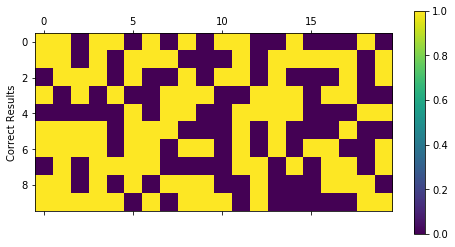

Final percentage:  tensor(0.5096)
Last epoch:  18


Best Score So Far:  tensor(-0.6898)


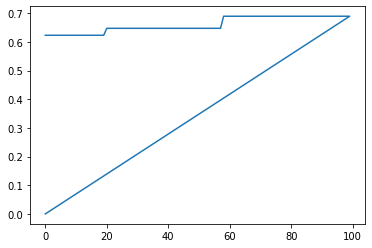

|  100      | -0.5096   |  60.15    |  1.56     |  0.02868  |  0.7077   |  1.771e+0 |  1.986    |  0.7169   |  42.9     |  0.3083   |  0.6497   |  2.944    |  0.5183   |  3.846    |  8.983    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.69653
    t0: 1000000.0
    weight_decay: 0.129515422635858
)
Batch Normalization Momentum:  0.7
Nodes:  44
LR:  0.69653
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.129515422635858
BATCH_SIZE:  67
Dropout:  0.36
Final Linear Layers:  3
average loss: 62.330105
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2093)
Class:  1  correct:  18.0  of  tensor(86.)


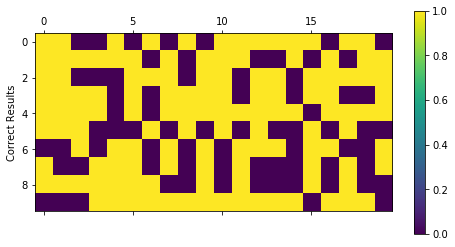

Final percentage:  tensor(0.5871)
Last epoch:  12


Best Score So Far:  tensor(-0.6898)


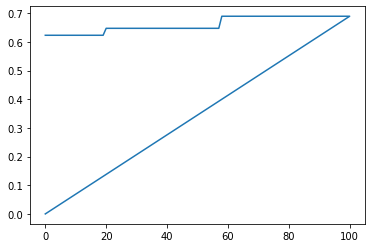

|  101      | -0.5871   |  67.27    |  1.742    |  0.7033   |  0.3645   |  1.605e+0 |  3.961    |  0.6965   |  44.12    |  0.08982  |  0.1295   |  2.048    |  0.4129   |  3.394    |  9.389    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  AdamW (
Parameter Group 0
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.00523
    weight_decay: 0.20577435358083385
)
Batch Normalization Momentum:  0.95
Nodes:  41
LR:  0.00523
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.20577435358083385
BATCH_SIZE:  24
Dropout:  0.77
Final Linear Layers:  1
average loss: 27.799503
average loss: 0.867694
average loss: 0.694871
average loss: 0.693180
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0614)
Class:  0  correct:  7.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.7791)
Class:  1  correct:  67.0  of  tensor(86.)


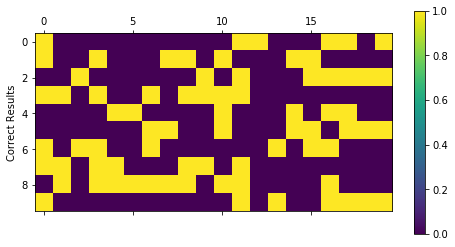

Final percentage:  tensor(0.4202)
Last epoch:  303


Best Score So Far:  tensor(-0.6898)


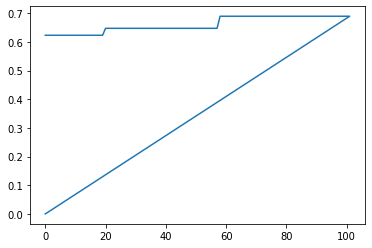

|  102      | -0.4202   |  24.41    |  2.712    |  0.9478   |  0.7676   |  1.038e+0 |  1.172    |  0.005228 |  41.4     |  0.05659  |  0.2058   |  1.708    |  0.9441   |  2.426    |  3.501    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.80146
    t0: 1000000.0
    weight_decay: 0.0711968750147217
)
Batch Normalization Momentum:  0.11
Nodes:  50
LR:  0.80146
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.0711968750147217
BATCH_SIZE:  65
Dropout:  0.61
Final Linear Layers:  3
average loss: 331.289215
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9825)
Class:  0  correct:  112.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1047)
Class:  1  correct:  9.0  of  tensor(86.)


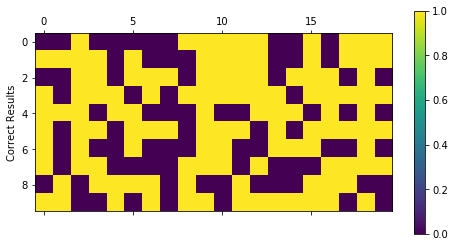

Final percentage:  tensor(0.5436)
Last epoch:  16


Best Score So Far:  tensor(-0.6898)


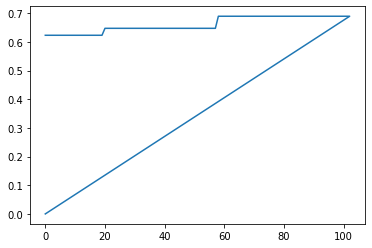

|  103      | -0.5436   |  65.38    |  2.28     |  0.1101   |  0.6064   |  1.852e+0 |  3.524    |  0.8015   |  50.11    |  0.4439   |  0.0712   |  1.449    |  0.9616   |  1.851    |  9.157    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.31061
    rho: 0.9
    weight_decay: 0.05873409019643782
)
Batch Normalization Momentum:  0.15
Nodes:  22
LR:  0.31061
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.05873409019643782
BATCH_SIZE:  114
Dropout:  0.7
Final Linear Layers:  1
average loss: 156.727966
average loss: 0.702997
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.0789)
Class:  0  correct:  9.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6977)
Class:  1  correct:  60.0  of  tensor(86.)


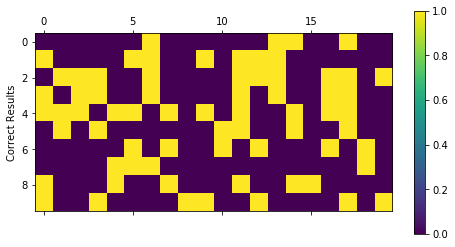

Final percentage:  tensor(0.3883)
Last epoch:  173


Best Score So Far:  tensor(-0.6898)


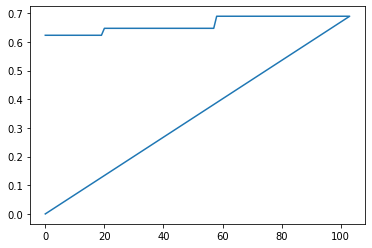

|  104      | -0.3883   |  114.2    |  2.836    |  0.1546   |  0.7038   |  1.632e+0 |  1.63     |  0.3106   |  22.15    |  0.4445   |  0.05873  |  1.329    |  0.1952   |  3.066    |  6.158    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.88571
    weight_decay: 0.15677238426223497
)
Batch Normalization Momentum:  0.62
Nodes:  3
LR:  0.88571
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.15677238426223497
BATCH_SIZE:  112
Dropout:  0.03
Final Linear Layers:  3
average loss: 90.369911
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8684)
Class:  0  correct:  99.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.4419)
Class:  1  correct:  38.0  of  tensor(86.)


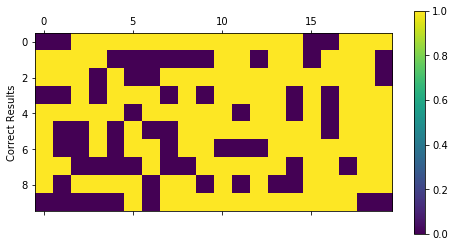

Final percentage:  tensor(0.6551)
Last epoch:  29


Best Score So Far:  tensor(-0.6898)


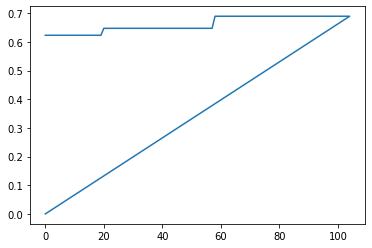

|  105      | -0.6551   |  112.0    |  1.487    |  0.6233   |  0.02755  |  1.516e+0 |  3.581    |  0.8857   |  3.244    |  0.2533   |  0.1568   |  1.095    |  0.01007  |  2.466    |  1.409    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.63227
    weight_decay: 0.2474407034664404
)
Batch Normalization Momentum:  0.29
Nodes:  64
LR:  0.63227
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.2474407034664404
BATCH_SIZE:  37
Dropout:  0.22
Final Linear Layers:  2
average loss: 500.720978
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2442)
Class:  1  correct:  21.0  of  tensor(86.)


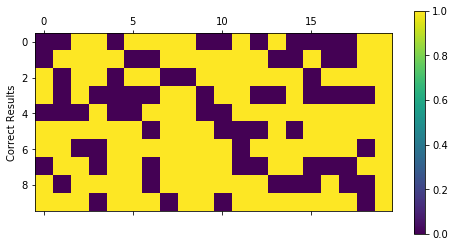

Final percentage:  tensor(0.6045)
Last epoch:  13


Best Score So Far:  tensor(-0.6898)


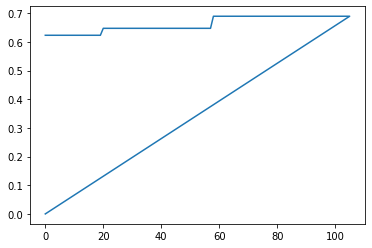

|  106      | -0.6045   |  37.07    |  2.274    |  0.2917   |  0.2157   |  1.591e+0 |  2.138    |  0.6323   |  64.51    |  0.6329   |  0.2474   |  1.571    |  0.1319   |  3.802    |  8.235    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.49629
    rho: 0.9
    weight_decay: 0.12980382039178529
)
Batch Normalization Momentum:  0.92
Nodes:  25
LR:  0.49629
RELU:  False
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.12980382039178529
BATCH_SIZE:  120
Dropout:  0.75
Final Linear Layers:  1
average loss: 203.019073
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9561)
Class:  0  correct:  109.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1744)
Class:  1  correct:  15.0  of  tensor(86.)


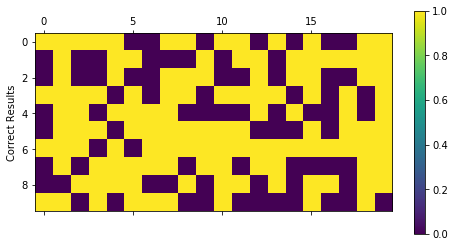

Final percentage:  tensor(0.5653)
Last epoch:  75


Best Score So Far:  tensor(-0.6898)


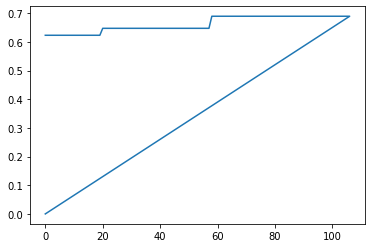

|  107      | -0.5653   |  120.2    |  1.369    |  0.9238   |  0.7486   |  1.284e+0 |  1.821    |  0.4963   |  25.35    |  0.4422   |  0.1298   |  2.885    |  0.4889   |  3.882    |  6.798    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.05343
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.14
Nodes:  64
LR:  0.05343
RELU:  True
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.5647420928613269
BATCH_SIZE:  63
Dropout:  0.51
Final Linear Layers:  2
average loss: 5.267147
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8246)
Class:  0  correct:  94.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.4651)
Class:  1  correct:  40.0  of  tensor(86.)


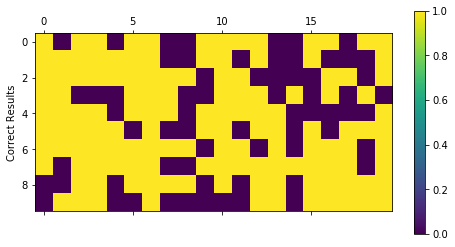

Final percentage:  tensor(0.6448)
Last epoch:  11


Best Score So Far:  tensor(-0.6898)


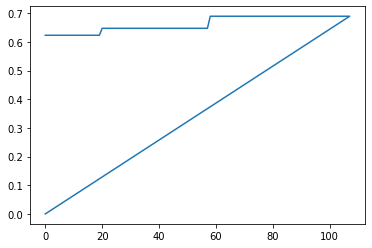

|  108      | -0.6448   |  63.02    |  2.926    |  0.1418   |  0.5059   |  1.662e+0 |  2.297    |  0.05343  |  64.08    |  0.4652   |  0.5647   |  1.511    |  0.3875   |  1.718    |  7.171    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.84164
    rho: 0.9
    weight_decay: 0.6634400698645146
)
Batch Normalization Momentum:  0.81
Nodes:  113
LR:  0.84164
RELU:  False
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.6634400698645146
BATCH_SIZE:  126
Dropout:  0.18
Final Linear Layers:  1
average loss: 186.588959
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9474)
Class:  0  correct:  108.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1628)
Class:  1  correct:  14.0  of  tensor(86.)


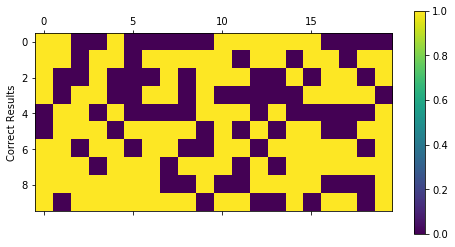

Final percentage:  tensor(0.5551)
Last epoch:  28


Best Score So Far:  tensor(-0.6898)


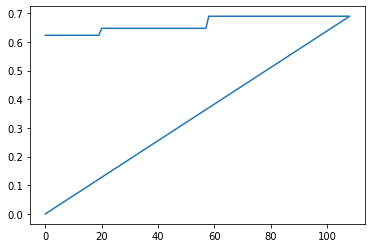

|  109      | -0.5551   |  126.7    |  1.353    |  0.8132   |  0.1848   |  1.058e+0 |  1.415    |  0.8416   |  114.0    |  0.2897   |  0.6634   |  2.691    |  0.4303   |  2.399    |  6.662    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.28949
    weight_decay: 0.1714919590694423
)
Batch Normalization Momentum:  0.26
Nodes:  100
LR:  0.28949
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.1714919590694423
BATCH_SIZE:  21
Dropout:  0.01
Final Linear Layers:  2
average loss: 189.146667
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9474)
Class:  0  correct:  108.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.2791)
Class:  1  correct:  24.0  of  tensor(86.)


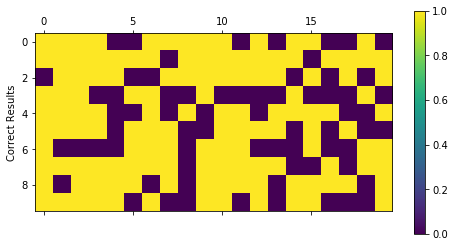

Final percentage:  tensor(0.6132)
Last epoch:  11


Best Score So Far:  tensor(-0.6898)


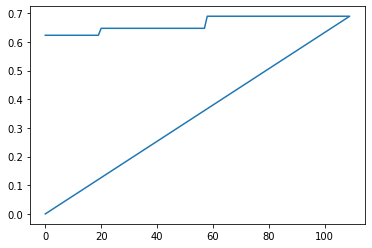

|  110      | -0.6132   |  21.91    |  1.029    |  0.2629   |  0.01235  |  1.674e+0 |  2.649    |  0.2895   |  100.3    |  0.1465   |  0.1715   |  1.582    |  0.194    |  1.263    |  8.821    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adamax (
Parameter Group 0
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.77441
    weight_decay: 0.5606214626555102
)
Batch Normalization Momentum:  0.12
Nodes:  44
LR:  0.77441
RELU:  False
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5606214626555102
BATCH_SIZE:  13
Dropout:  0.01
Final Linear Layers:  3
average loss: 102.429710
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.8684)
Class:  0  correct:  99.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3605)
Class:  1  correct:  31.0  of  tensor(86.)


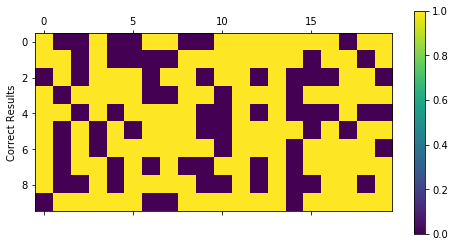

Final percentage:  tensor(0.6144)
Last epoch:  9


Best Score So Far:  tensor(-0.6898)


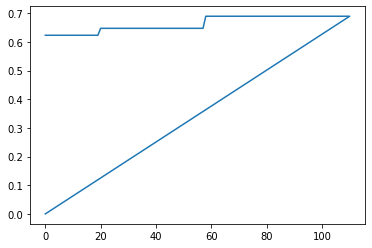

|  111      | -0.6144   |  13.11    |  2.361    |  0.1192   |  0.008559 |  1.557e+0 |  3.712    |  0.7744   |  44.64    |  0.0281   |  0.5606   |  2.604    |  0.8598   |  3.002    |  8.262    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Rprop (
Parameter Group 0
    etas: (0.5, 1.2)
    lr: 0.46829
    step_sizes: (1e-06, 50)
)
Batch Normalization Momentum:  0.55
Nodes:  106
LR:  0.46829
RELU:  True
BIAS:  True
Loss Type:  3
REGULARIZATION:  0.5774185078134237
BATCH_SIZE:  115
Dropout:  0.4
Final Linear Layers:  3
average loss: 395.076477
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0233)
Class:  1  correct:  2.0  of  tensor(86.)


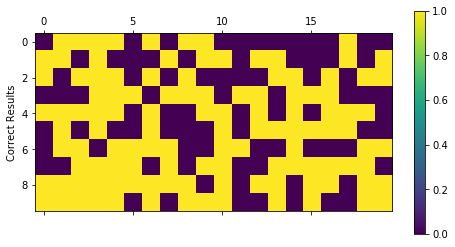

Final percentage:  tensor(0.5116)
Last epoch:  8


Best Score So Far:  tensor(-0.6898)


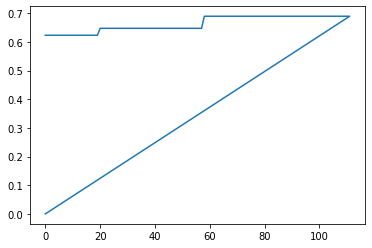

|  112      | -0.5116   |  115.1    |  1.903    |  0.5522   |  0.4049   |  1.692e+0 |  3.042    |  0.4683   |  106.4    |  0.5058   |  0.5774   |  1.561    |  0.1767   |  3.9      |  7.67     |
*** LOSS ******: 2
*********  MMLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.20205
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.95
Nodes:  98
LR:  0.20205
RELU:  True
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.46636504434742426
BATCH_SIZE:  34
Dropout:  0.06
Final Linear Layers:  2
average loss: 222.638489
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0116)
Class:  1  correct:  1.0  of  tensor(86.)


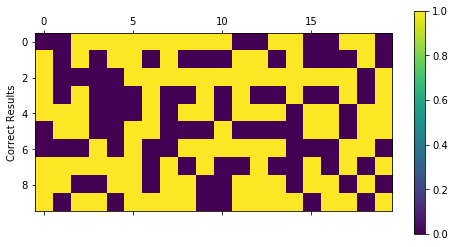

Final percentage:  tensor(0.5058)
Last epoch:  11


Best Score So Far:  tensor(-0.6898)


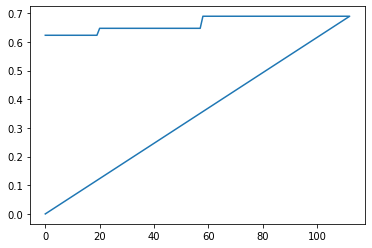

|  113      | -0.5058   |  34.73    |  2.157    |  0.9457   |  0.0646   |  1.084e+0 |  2.851    |  0.2021   |  98.41    |  0.568    |  0.4664   |  1.215    |  0.08344  |  2.869    |  4.683    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.86542
    rho: 0.9
    weight_decay: 0.5206500625262186
)
Batch Normalization Momentum:  0.67
Nodes:  93
LR:  0.86542
RELU:  True
BIAS:  True
Loss Type:  2
REGULARIZATION:  0.5206500625262186
BATCH_SIZE:  12
Dropout:  0.15
Final Linear Layers:  3
average loss: 16.585081
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(1.)
Class:  0  correct:  114.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.)
Class:  1  correct:  0.0  of  tensor(86.)


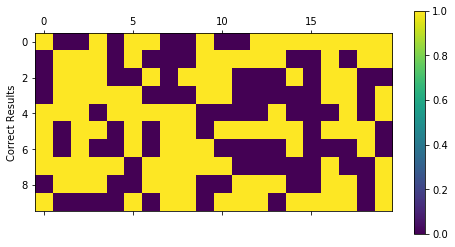

Final percentage:  tensor(0.5000)
Last epoch:  10


Best Score So Far:  tensor(-0.6898)


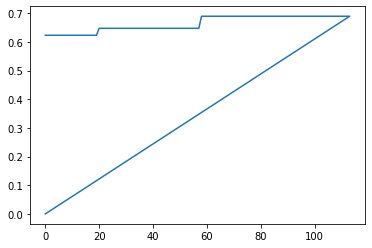

|  114      | -0.5      |  12.99    |  1.738    |  0.6654   |  0.1517   |  1.896e+0 |  3.84     |  0.8654   |  93.99    |  0.4065   |  0.5207   |  1.573    |  0.3113   |  2.812    |  6.348    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.99)
    eps: 1e-08
    lr: 0.59134
    weight_decay: 0.5993258506673614
)
Batch Normalization Momentum:  0.76
Nodes:  108
LR:  0.59134
RELU:  True
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.5993258506673614
BATCH_SIZE:  112
Dropout:  0.75
Final Linear Layers:  2
average loss: 3134.110596
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.3333)
Class:  0  correct:  38.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.3837)
Class:  1  correct:  33.0  of  tensor(86.)


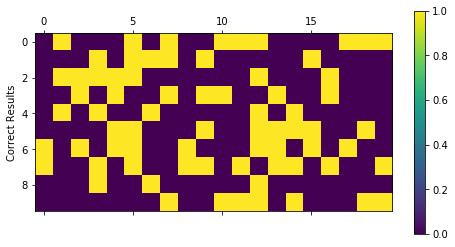

Final percentage:  tensor(0.3585)
Last epoch:  12


Best Score So Far:  tensor(-0.6898)


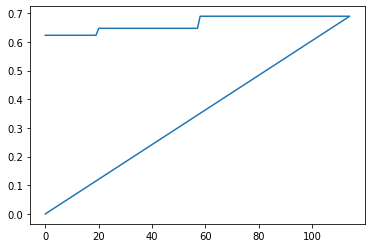

|  115      | -0.3585   |  112.7    |  1.507    |  0.7585   |  0.7528   |  1.001e+0 |  2.424    |  0.5913   |  108.3    |  0.1844   |  0.5993   |  1.725    |  0.8834   |  1.083    |  1.768    |
*** LOSS ******: 2
*********  MMLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.28046
    rho: 0.9
    weight_decay: 0.45561679654732035
)
Batch Normalization Momentum:  0.41
Nodes:  42
LR:  0.28046
RELU:  False
BIAS:  False
Loss Type:  2
REGULARIZATION:  0.45561679654732035
BATCH_SIZE:  125
Dropout:  0.14
Final Linear Layers:  1
average loss: 318.771881
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.)
Class:  0  correct:  0.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.9767)
Class:  1  correct:  84.0  of  tensor(86.)


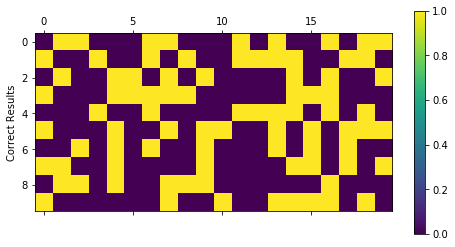

Final percentage:  tensor(0.4884)
Last epoch:  13


Best Score So Far:  tensor(-0.6898)


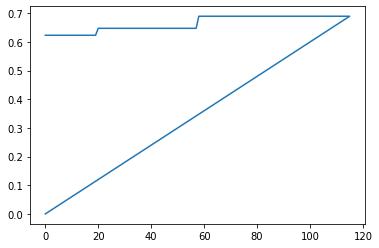

|  116      | -0.4884   |  125.7    |  2.213    |  0.4135   |  0.1354   |  1.65e+03 |  1.111    |  0.2805   |  42.76    |  0.6072   |  0.4556   |  2.684    |  0.9183   |  2.975    |  6.198    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.61386
    t0: 1000000.0
    weight_decay: 0.3559865611993882
)
Batch Normalization Momentum:  0.15
Nodes:  31
LR:  0.61386
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3559865611993882
BATCH_SIZE:  52
Dropout:  0.72
Final Linear Layers:  2
average loss: 3.054806
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.1316)
Class:  0  correct:  15.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.6163)
Class:  1  correct:  53.0  of  tensor(86.)


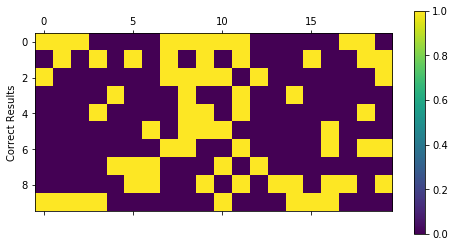

Final percentage:  tensor(0.3739)
Last epoch:  10


Best Score So Far:  tensor(-0.6898)


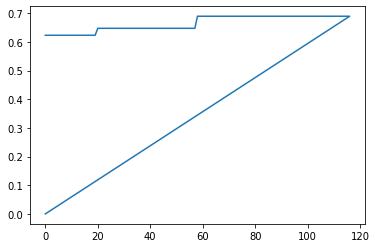

|  117      | -0.3739   |  52.24    |  2.924    |  0.1525   |  0.7161   |  1.311e+0 |  2.64     |  0.6139   |  31.8     |  0.1684   |  0.356    |  2.576    |  0.6855   |  1.356    |  9.098    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  RMSprop (
Parameter Group 0
    alpha: 0.99
    centered: False
    eps: 1e-08
    lr: 0.63534
    momentum: 0
    weight_decay: 0
)
Batch Normalization Momentum:  0.55
Nodes:  114
LR:  0.63534
RELU:  False
BIAS:  False
Loss Type:  1
REGULARIZATION:  0.3696481775066745
BATCH_SIZE:  62
Dropout:  0.07
Final Linear Layers:  3
average loss: 98.100105
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9649)
Class:  0  correct:  110.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0233)
Class:  1  correct:  2.0  of  tensor(86.)


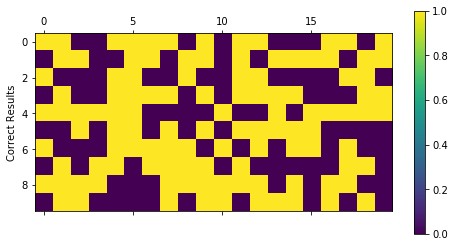

Final percentage:  tensor(0.4941)
Last epoch:  10


Best Score So Far:  tensor(-0.6898)


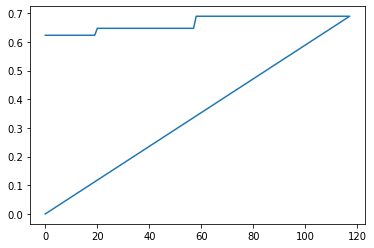

|  118      | -0.4941   |  62.45    |  2.884    |  0.5479   |  0.06784  |  1.202e+0 |  3.554    |  0.6353   |  114.8    |  0.3295   |  0.3696   |  2.294    |  0.5883   |  1.692    |  4.837    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.5629
    rho: 0.9
    weight_decay: 0.25986591440546436
)
Batch Normalization Momentum:  0.98
Nodes:  34
LR:  0.5629
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.25986591440546436
BATCH_SIZE:  33
Dropout:  0.05
Final Linear Layers:  1
average loss: 429.920258
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.0930)
Class:  1  correct:  8.0  of  tensor(86.)


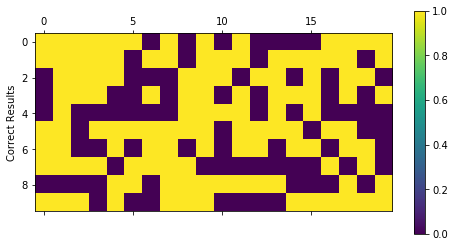

Final percentage:  tensor(0.5421)
Last epoch:  18


Best Score So Far:  tensor(-0.6898)


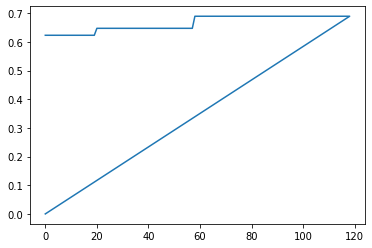

|  119      | -0.5421   |  33.26    |  2.683    |  0.9768   |  0.05326  |  1.714e+0 |  1.987    |  0.5629   |  34.52    |  0.6507   |  0.2599   |  1.587    |  0.9026   |  3.818    |  6.516    |
*** LOSS ******: 3
*********  NLLLoss
Optimization:  Adadelta (
Parameter Group 0
    eps: 1e-06
    lr: 0.21609
    rho: 0.9
    weight_decay: 0.5196941624520004
)
Batch Normalization Momentum:  0.74
Nodes:  81
LR:  0.21609
RELU:  True
BIAS:  False
Loss Type:  3
REGULARIZATION:  0.5196941624520004
BATCH_SIZE:  29
Dropout:  0.6
Final Linear Layers:  3
average loss: 343.075653
Loaded the model with the lowest Validation Loss!
Class:  0  accuracy:  tensor(0.9912)
Class:  0  correct:  113.0  of  tensor(114.)
Class:  1  accuracy:  tensor(0.1279)
Class:  1  correct:  11.0  of  tensor(86.)


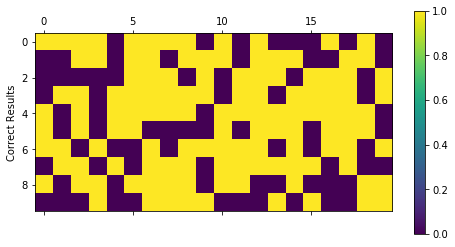

Final percentage:  tensor(0.5596)
Last epoch:  23


Best Score So Far:  tensor(-0.6898)


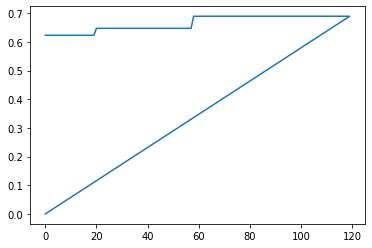

|  120      | -0.5596   |  29.02    |  2.869    |  0.7429   |  0.6009   |  1.212e+0 |  3.482    |  0.2161   |  81.58    |  0.7103   |  0.5197   |  1.777    |  0.7522   |  3.7      |  6.281    |
*** LOSS ******: 1
*********  CrossEntropyLoss
Optimization:  ASGD (
Parameter Group 0
    alpha: 0.75
    lambd: 0.0001
    lr: 0.03548
    t0: 1000000.0
    weight_decay: 0.6814658506993219
)
Batch Normalization Momentum:  0.1
Nodes:  32
LR:  0.03548
RELU:  False
BIAS:  True
Loss Type:  1
REGULARIZATION:  0.6814658506993219
BATCH_SIZE:  13
Dropout:  0.14
Final Linear Layers:  3
average loss: 73.634460


In [ ]:


if OPTIMIZATION_PLUGIN == 'Bayesian' :
    from bayes_opt import BayesianOptimization
    
    #def black_box_function(x, y):
    def objective(SCI_RELU, SCI_BIAS, SCI_loss_type,
                  SCI_optimizer, SCI_LR, SCI_MM, 
                  SCI_REGULARIZATION, SCI_EPOCHS, SCI_BATCH_SIZE, 
                  SCI_DROPOUT, SCI_L_SECOND, SCI_BN_MOMENTUM, SCI_SGD_MOMENTUM, SCI_LINEARITY):
        global count, PercentVector, PercentVec, device, MaxPercent

        
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)                    # integer between 4 and 256
        SCI_MM = round(SCI_MM,3)                                # real with three decimals between (0.001, 0.999)
        SCI_LR = round(SCI_LR,5)                                # real with five decimals between(1e-4, 7e-1)            
        SCI_DROPOUT = round(SCI_DROPOUT,2)                      # real with two decimals between (0, 0.4)
        SCI_L_SECOND = int(SCI_L_SECOND)                        # integer between 2 and 64
        SCI_EPOCHS = int(SCI_EPOCHS)                            # integer between (100, 500)
        SCI_BN_MOMENTUM = round(SCI_BN_MOMENTUM,2)              # real with two decimals between (0, 0.99)
        SCI_SGD_MOMENTUM = round(SCI_SGD_MOMENTUM,2)            # real with two decimals between (0, 0.99) 
        SCI_loss_type = int(SCI_loss_type)                      # integer between 1 and 3 ('CrossEntropyLoss', 'MultiMarginLoss','NLLLoss')
        SCI_LINEARITY = int(SCI_LINEARITY)
        if int(SCI_RELU) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_RELU = True      
        else:
            SCI_RELU = False      
        if int(SCI_BIAS) == 1 :                                 # integer between 1 and 2 ('True', 'False')
            SCI_BIAS = True      
        else:
            SCI_BIAS = False  
 
        SCI_REGULARIZATION = float(str(SCI_REGULARIZATION))
        
        cnn = CNN6(L_FIRST, SCI_L_SECOND, KERNEL_X,
                   SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU,
                   SCI_DROPOUT, dataset.CLASSES, SCI_LINEARITY)     

        optimizer = Utillities.optimization_algorithms(SCI_optimizer,cnn, SCI_LR, SCI_SGD_MOMENTUM,
                                                       SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim = 0) 
            cnn = cnn.cuda()                
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)        
        cnn.share_memory()
     
        loss_func = nn.CrossEntropyLoss()

        def create_loss(LOSS):   
            print('*** LOSS ******:',  LOSS)
            if LOSS == 1:
                loss_func = nn.CrossEntropyLoss()
                print('*********  CrossEntropyLoss')
            if LOSS == 2:
                loss_func = nn.MultiMarginLoss()
                print('*********  MMLoss')                               
            if LOSS == 3:
                loss_func = nn.NLLLoss() 
                print('*********  NLLLoss')                 
            return loss_func

        MM = float(str(SCI_MM))

        LR = float(str(SCI_LR))
        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)
    
        loss_type = create_loss(SCI_loss_type)
    
        Utillities.listing(optimizer, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, 
                           SCI_L_SECOND, SCI_LR, SCI_RELU, 
                           SCI_BIAS, SCI_loss_type, SCI_REGULARIZATION, 
                           SCI_BATCH_SIZE, SCI_DROPOUT, SCI_LINEARITY)

    
        # Data Loader for easy mini-batch return in training
        SCI_BATCH_SIZE = int(SCI_BATCH_SIZE)
        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = SCI_BATCH_SIZE, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 190, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 200, shuffle = True, num_workers = 0, drop_last=True, pin_memory=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                # forward pass: compute predicted outputs by passing inputs to the model     
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())              # record training loss 
                loss.backward()                               # backward pass: compute gradient of the loss with respect to model parameters
                optimizer.zero_grad()
                optimizer.step()                              # perform a single optimization step (parameter update)
      
            cnn.eval().cuda()                 # switch to evaluation (no change) mode           
            valid_loss = 0
            accuracy = 0
            running_loss = 0.0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()
                running_loss += valid_loss
                if epoch % 100 == 0: 
                    print('average loss: %.6f' %(running_loss))
                    running_loss = 0.0
                   
            train_losses = []
            early_stopping(valid_loss, cnn)
        
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    #cnn = TheModelClass(*args, **kwargs)
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt'))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                dx = ((c.cpu()).numpy()).astype(int)
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])   
            print('Class: ',i,' correct: ', class_correct[i],' of ',dataset.TESTED_ELEMENTS[i])

        plt.matshow(dx.reshape((10, 20)))
        plt.ylabel('Correct Results')
        plt.colorbar()
        plt.show()
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = int((1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1])
        
    
        print('Last epoch: ', epoch)
    
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        print()
        
        if -percent < MaxPercent : 
            MaxPercent = -percent
        print('Best Score So Far: ',MaxPercent)    
        
        PercentVector[count] = MaxPercent    
        PercentVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(PercentVec, -PercentVector, color='tab:blue')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
        
        return -percent
    
    
    optimizer = BayesianOptimization(
        f=objective,
        #pbounds=pbounds,
        pbounds={'SCI_RELU': (1,2.99), 
                 'SCI_BIAS': (1,2.99), 
                 'SCI_loss_type': (1, 3.99), 
                 'SCI_optimizer': (1, 9.99),
                 'SCI_LR': (0.00001, 0.9), 
                 'SCI_MM': (0.001, 0.999), 
                 'SCI_REGULARIZATION': (0.0001, 0.7), 
                 'SCI_EPOCHS': (1000, 2000), 
                 'SCI_BATCH_SIZE': (2, 128), 
                 'SCI_DROPOUT': (0, 0.8), 
                 'SCI_L_SECOND': (2, 128), 
                 'SCI_BN_MOMENTUM': (0, 0.99), 
                 'SCI_SGD_MOMENTUM': (0, 0.99), 
                 'SCI_LINEARITY': (1,3.99)},
        verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
        random_state=1,
    )
        

    #optimizer.maximize(
        #n_iter=TRIALS, acq="ucb", kappa=0.1
    #)
    
    
    optimizer.maximize(
        init_points = RANDOM_STARTS,
        n_iter = TRIALS,
        #acq="ucb", kappa=0.1
        
        acq="ei", xi=1e-4
    )
    
    
    print(optimizer.max)
    
    for i, res in enumerate(optimizer.res):
        print("Iteration {}: \n\t{}".format(i, res))

In [ ]:
if OPTIMIZATION_PLUGIN == 'GradDescent' :
    import pandas as pd
    import matplotlib.pyplot as plt
    import torch
    import torch.optim as optim
    from torch.autograd import Variable
    from Utillities import Utillities
    from cnn_model import CNN6      

    #SCI_LR = 0.2
    SCI_REGULARIZATION = 0.03
    SCI_EPOCHS = 200
    SCI_RELU = 'True'
    SCI_BIAS = 'True'
    SCI_BN_MOMENTUM = 0.1
    
    
    SCI_loss_type = torch.randint(3, 4, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_loss_type: ',SCI_loss_type)    
    SCI_SGD_MOMENTUM = torch.rand(1, requires_grad=True)
    print('SCI_SGD_MOMENTUM: ', SCI_SGD_MOMENTUM)
    SCI_BATCH_SIZE   = torch.randint(128, 256, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_BATCH_SIZE: ',SCI_BATCH_SIZE)
    SCI_L_SECOND   = torch.randint(80, 96, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_L_SECOND: ',SCI_L_SECOND)
    SCI_optimizer   = torch.randint(6, 11, (1,1), dtype=torch.float, requires_grad=True) 
    print('SCI_optimizer: ',SCI_optimizer)    
    SCI_DROPOUT      = torch.rand(1, requires_grad=True)    
    print('SCI_DROPOUT: ',SCI_DROPOUT)   
    SCI_LR      = torch.rand(1, requires_grad=True)    
    print('SCI_LR: ',SCI_LR) 
    

    def objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY, SCI_loss_type, SCI_LR):
        global SCI_REGULARIZATION, SCI_EPOCHS, SCI_RELU
        global SCI_BIAS, SCI_BN_MOMENTUM, device, MaxCredit, count, CreditVector, CreditVec
        
        SCI_SGD_MOMENTUM = SCI_SGD_MOMENTUM/10
        DROPOUT = (SCI_DROPOUT/2).item()
        if SCI_DROPOUT < 0 :
            DROPOUT = 0
            
        if SCI_BATCH_SIZE < 2 :
            SCI_BATCH_SIZE = 64            

        BATCH_SIZE = int(SCI_BATCH_SIZE)
        
        if SCI_L_SECOND < 4 :
            SCI_L_SECOND = 64
            
        
        L_SECOND = int(SCI_L_SECOND)
        
        def create_loss(LOSS):   
            print('*** LOSS ******:',  LOSS)
            if LOSS == 1:
                loss_func = nn.CrossEntropyLoss()
                print('*********  CrossEntropyLoss')
            if LOSS == 2:
                loss_func = nn.MultiMarginLoss()
                print('*********  MMLoss')                               
            if LOSS == 3:
                loss_func = nn.NLLLoss() 
                print('*********  NLLLoss')                 
            return loss_func

        SCI_LR = SCI_LR.item() / 3
        print('SCI_LR: ', SCI_LR)
        print('SCI_LR type: ', type(SCI_LR))


        
        loss_type = int(SCI_loss_type)
        loss_func = create_loss(loss_type)
        print('LOSS FUNCTION IS: ',loss_func)

        REGULARIZATION = float(str(SCI_REGULARIZATION))

        cnn = CNN6(L_FIRST, L_SECOND, KERNEL_X, SCI_BIAS, SCI_BN_MOMENTUM, SCI_RELU, DROPOUT, dataset.CLASSES, LINEARITY)     

        optimizer1 = Utillities.optimization_algorithms(SCI_optimizer.detach().numpy(),cnn, SCI_LR, SCI_SGD_MOMENTUM, SCI_REGULARIZATION)
        
        if GPU_SELECT == 2:
            if torch.cuda.device_count() > 1:
                cnn = nn.DataParallel(cnn,device_ids=[0, 1], dim=0) 
            cnn = cnn.cuda()
        if GPU_SELECT == 1:
            cnn.to(device)  
        if GPU_SELECT == 0:
            cnn.to(device)        

        cnn.apply(CNN6.weights_reset)
        cnn.share_memory()


        train_losses = []         # to track the training loss as the model trains
        output = 0
        loss = 0
        accuracy = 0
        early_stopping.counter = 0
        early_stopping.best_score = None
        early_stopping.early_stop = False
        early_stopping.verbose = False  
        TEST_RESULTS = torch.zeros(1,2)

    
        Utillities.listing(optimizer1, SCI_SGD_MOMENTUM, SCI_BN_MOMENTUM, L_SECOND, SCI_LR, SCI_RELU, SCI_BIAS, loss_type, REGULARIZATION, BATCH_SIZE, DROPOUT, LINEARITY)

        train_loader = Data.DataLoader(dataset = dataset.train_dataset, batch_size = BATCH_SIZE, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)
        validation_loader = Data.DataLoader(dataset = dataset.validation_dataset, batch_size = 144, shuffle = False, num_workers = 0, drop_last=True, pin_memory=True)    
        test_loader = Data.DataLoader(dataset = dataset.test_dataset, batch_size = 599, shuffle = False, num_workers = 0, pin_memory=True, drop_last=True)
    
        for epoch in range(SCI_EPOCHS):
            loss = None        
            cnn.train().cuda()
            for step, (train_data, train_target) in enumerate(train_loader):   
                train_data, train_target = train_data.to(device), train_target.to(device)
                output, temp = cnn(train_data)                   
                loss = loss_func(output, train_target)
                train_losses.append(loss.item())            
                loss.backward()                             
                optimizer1.zero_grad()
                optimizer1.step()                           
      
            cnn.eval().cuda()                   
            valid_loss = 0
            accuracy = 0
            with torch.no_grad():
                for step, (validation_data, validation_target) in enumerate(validation_loader):
                    validation_data, validation_target = validation_data.to(device), validation_target.to(device)
                    output, temp = cnn(validation_data)            # forward pass: compute predicted outputs by passing inputs to the model
                    valid_loss += loss_func(output, validation_target).item()  
               
            train_losses = []
            early_stopping(valid_loss, cnn)
       
            if early_stopping.early_stop:
                if os.path.exists('checkpoint.pt'):
                    print("Loaded the model with the lowest Validation Loss!")
                    cnn.load_state_dict(torch.load('checkpoint.pt', map_location="cuda:1"))  # Choose whatever GPU device number you want
                    cnn.to(device)
                break
      
        cnn.eval()
        class_correct = list(0. for i in range(1000))
        class_total = list(0. for i in range(1000))
        with torch.no_grad():
            for (test_data, test_target) in test_loader:
                test_data, test_target = test_data.to(device), test_target.to(device)
                outputs, temp = cnn(test_data)
                _, predicted = torch.max(outputs, 1)
                c = (predicted == test_target).squeeze()
                for i in range(test_target.size(0)):
                    label = test_target[i]
                    class_correct[label] += c[i].item()
                    class_total[label] += 1

        for i in range(dataset.CLASSES):
            TEST_RESULTS[0,i] = class_correct[i] / dataset.TESTED_ELEMENTS[i]
            print('Class: ',i,' accuracy: ', TEST_RESULTS[0,i])
            print('Class: ',i,' correct: ', class_correct[i])
        percent = (TEST_RESULTS[0,0]+TEST_RESULTS[0,1])/2
        print('Final percentage: ',percent)
    
        CreditCost = (1 - TEST_RESULTS[0,0]) * dataset.TESTED_ELEMENTS[0] + (1 - TEST_RESULTS[0,1]) * dataset.TESTED_ELEMENTS[1] * 5
    
        if TEST_RESULTS[0,0] == 0 or TEST_RESULTS[0,1] == 0 :
            CreditCost = CreditCost + 300
    
        print('Last epoch: ', epoch)
   
        if os.path.exists('checkpoint.pt'):  
            os.remove('checkpoint.pt') 

        print()
        torch.cuda.empty_cache()
        print()
        
        CreditCost = CreditCost + (SCI_SGD_MOMENTUM + SCI_DROPOUT + SCI_BATCH_SIZE + SCI_L_SECOND + SCI_optimizer + SCI_loss_type+ SCI_LR)/1000
        print('Credit Cost: ',CreditCost)
        
        
        if -CreditCost > MaxCredit : 
            MaxCredit = -CreditCost
        print('Best Score So Far: ',MaxCredit)   
        
        CreditVector[count] = MaxCredit    
        CreditVec[count] = count
        # plot the data
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
        ax.plot(CreditVec, -CreditVector, color='tab:orange')
        #print(CreditVec, -CreditVector)
        count = count + 1
        # display the plot
        plt.show()
             
        return CreditCost

    
    def loss(y_predicted, expected):
        return (y_predicted - expected).sum()
            
    
    expected = 250
    
    optim_alg = optim.Adadelta([       
        {'params': SCI_SGD_MOMENTUM, 'lr': 0.9},
        {'params': SCI_DROPOUT, 'lr': 1e-2},
        {'params': SCI_BATCH_SIZE, 'lr': 1},
        {'params': SCI_L_SECOND, 'lr': 1},
        {'params': SCI_optimizer, 'lr': 0.9},
        {'params': SCI_loss_type, 'lr': 0.6}, 
        {'params': SCI_LR, 'lr': 0.1}   
        ]) 
    
    LINEARITY = 2
    # Main optimization loop
    for t in range(RANDOM_STARTS + TRIALS):
        optim_alg.zero_grad()
        y_predicted = objective(SCI_SGD_MOMENTUM, SCI_DROPOUT, SCI_BATCH_SIZE, SCI_L_SECOND, SCI_optimizer, LINEARITY, SCI_loss_type, SCI_LR)
        current_loss = loss(y_predicted, expected)
        current_loss.backward()
        optim_alg.step()
        print(f"t = {t}, loss = {current_loss}, SCI_DROPOUT = {SCI_DROPOUT.detach().numpy()}, SCI_SGD_MOMENTUM = {SCI_SGD_MOMENTUM.item()}, SCI_BATCH_SIZE = {SCI_BATCH_SIZE.detach().numpy()}, SCI_L_SECOND = {SCI_L_SECOND.detach().numpy()}, SCI_optimizer = {SCI_optimizer.detach().numpy()}, SCI_loss_type = {SCI_loss_type.detach().numpy()}, SCI_LR = {SCI_LR.detach().numpy()}")
    

In [ ]:
end.record()

#print('Minimum Credit Cost: ',Min_Credit_Cost)

print()
print('Total execution time (minutes): ',start.elapsed_time(end)/60000)

torch.cuda.empty_cache()

if GET_STATS:
    pr.disable()
    s = io.StringIO()
    sortby = SortKey.CUMULATIVE
    ps = pstats.Stats(pr, stream=s).sort_stats(sortby)
    ps.print_stats()
    print(s.getvalue())